# Phase 4. Extensions

## Pipeline requested for the extension

**Object detection**

- leveraging already existing and trained YOLO model we'll be able to find BBox for RGB images

**ROI**

- for each BBox crop RGB image accordingly
- crop the same exact point on corresponding depth file

**Feat extraction**

Feature extraction happens leveraging two different CNNs:
- *RGB Branch*: feature extraction from RGB cropped image
- *Depth Branch*: feature extraction from depth cropped image. Depth is threated as a 2D image, not a cloud of dots.

**Fusion**

$f_{\text{fused}}=concat(f_{\text{rgb}},f_{\text{depth}})$

**Pose estimation**

Pose estimation is done by a regressor (MLP)

# Step 1: Object detection

In [43]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from config import Config
from models.yolo_detector import YOLODetector

print(f"✅ Imports completati")
print(f"   Device: {Config.DEVICE}")
print(f"   PyTorch: {torch.__version__}")

✅ Imports completati
   Device: cuda
   PyTorch: 2.7.1+cu118


In [44]:
# Load pre-trained YOLO model
yolo_ckpt = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train20' / 'weights' / 'best.pt'

if yolo_ckpt.exists():
    yolo_detector = YOLODetector(
        model_name=str(yolo_ckpt),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO loaded from: {yolo_ckpt}")
else:
    raise FileNotFoundError(f"YOLO checkpoint not found: {yolo_ckpt}")

✅ Loading custom weights from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\yolo\yolo_train20\weights\best.pt
✅ YOLO loaded from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\yolo\yolo_train20\weights\best.pt


In [45]:
# Test YOLO detection on a sample image
from dataset.linemod_pose import LineMODPoseDataset

# Load test dataset to get sample images
test_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE
)

# Get a sample
sample = test_dataset[0]
rgb_path = sample['rgb_path']
depth_path = sample['depth_path']
gt_bbox = sample['bbox'].numpy()  # Ground truth bbox [x, y, w, h]

print(f"📷 Sample image: {rgb_path}")
print(f"📏 GT BBox [x,y,w,h]: {gt_bbox}")

📷 Sample image: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\data\Linemod_preprocessed\data\01\rgb\0004.png
📏 GT BBox [x,y,w,h]: [        246         191          43          56]


In [46]:
# Run YOLO detection
image_bgr = cv2.imread(rgb_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

detections = yolo_detector.detect_objects(image_bgr, conf_threshold=0.3)

print(f"🎯 Detected {len(detections)} object(s)")
for i, det in enumerate(detections):
    print(f"   [{i+1}] Class: {det['class_name']}, Conf: {det['confidence']:.2f}, BBox: {det['bbox']}")

🎯 Detected 1 object(s)
   [1] Class: ape, Conf: 0.93, BBox: [     245.76      190.09      288.26      247.09]


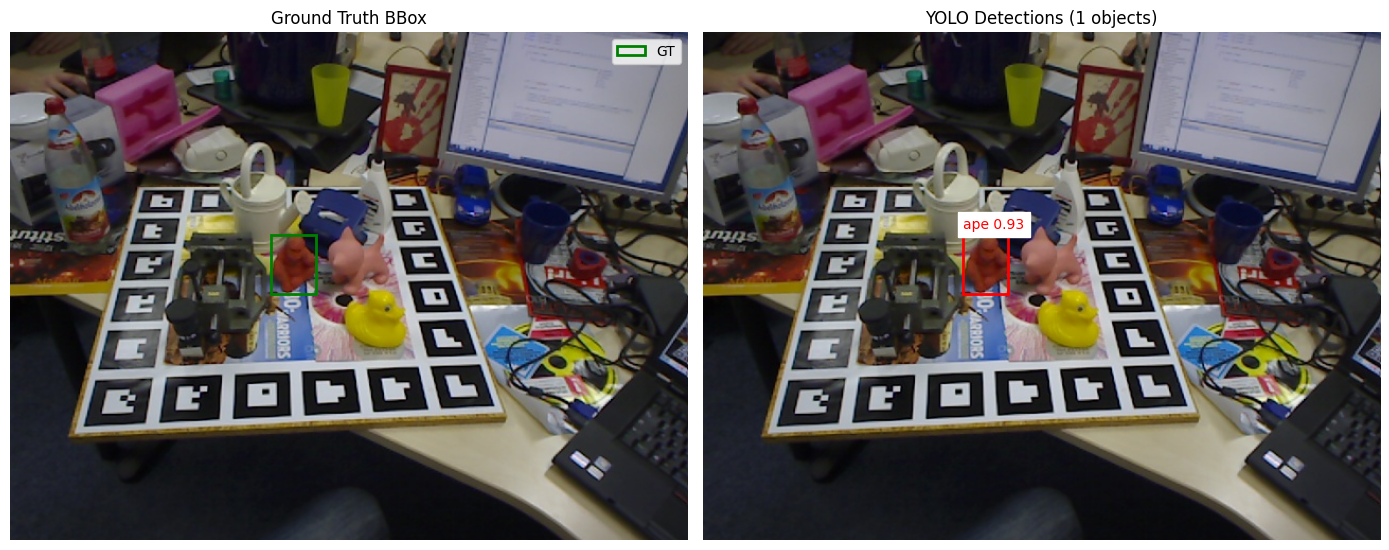


✅ Step 1 completed: Object detection with pre-trained YOLO


In [47]:
# Visualize detection results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original image with GT bbox
axes[0].imshow(image_rgb)
x, y, w, h = gt_bbox
rect_gt = plt.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2, label='GT')
axes[0].add_patch(rect_gt)
axes[0].set_title('Ground Truth BBox')
axes[0].legend()
axes[0].axis('off')

# Image with YOLO detections
axes[1].imshow(image_rgb)
for det in detections:
    x1, y1, x2, y2 = det['bbox']
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{det['class_name']} {det['confidence']:.2f}", 
                 color='red', fontsize=10, backgroundcolor='white')
axes[1].set_title(f'YOLO Detections ({len(detections)} objects)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Step 1 completed: Object detection with pre-trained YOLO")

# Step 2: ROI - Crop RGB and Depth

For each detected bounding box:
1. Crop the RGB image with a margin
2. Crop the corresponding depth map at the **same exact coordinates**
3. Resize both to a fixed size (224x224) for the CNN

In [48]:
def crop_roi(image: np.ndarray, bbox_xyxy: np.ndarray, margin: float = 0.15, output_size: int = 224):
    """
    Crop a region of interest from an image given a bounding box.
    
    Args:
        image: Input image (H, W, C) for RGB or (H, W) for depth
        bbox_xyxy: Bounding box [x1, y1, x2, y2]
        margin: Margin to add around the bbox (as fraction of bbox size)
        output_size: Output size for the crop (square)
    
    Returns:
        Cropped and resized image
    """
    x1, y1, x2, y2 = bbox_xyxy
    w, h = x2 - x1, y2 - y1
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Add margin and make it square
    size = max(w, h) * (1 + margin)
    half = size / 2
    
    # Compute crop coordinates (clipped to image bounds)
    img_h, img_w = image.shape[:2]
    x1_crop = int(max(0, cx - half))
    y1_crop = int(max(0, cy - half))
    x2_crop = int(min(img_w, cx + half))
    y2_crop = int(min(img_h, cy + half))
    
    # Crop
    if image.ndim == 3:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop, :]
    else:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop]
    
    # Resize to output size
    interp = cv2.INTER_LINEAR if image.ndim == 3 else cv2.INTER_NEAREST
    crop_resized = cv2.resize(crop, (output_size, output_size), interpolation=interp)
    
    return crop_resized


# Test on the first detection
if len(detections) > 0:
    det = detections[0]
    bbox = det['bbox']
    
    print(f"🎯 Using detection: {det['class_name']} (conf: {det['confidence']:.2f})")
    print(f"   BBox [x1,y1,x2,y2]: {bbox}")
else:
    # Fallback to GT bbox if no detection
    x, y, w, h = gt_bbox
    bbox = np.array([x, y, x+w, y+h])
    print(f"⚠️ No YOLO detection, using GT bbox: {bbox}")

🎯 Using detection: ape (conf: 0.93)
   BBox [x1,y1,x2,y2]: [     245.76      190.09      288.26      247.09]


In [49]:
# Crop RGB image
rgb_crop = crop_roi(image_rgb, bbox, margin=0.15, output_size=224)

# Load and crop depth image
depth_raw = np.array(Image.open(depth_path))  # uint16, values in mm
depth_crop = crop_roi(depth_raw, bbox, margin=0.15, output_size=224)

# Normalize depth to [0, 1] for visualization and network input
DEPTH_MAX = 2000.0  # mm (typical max depth in LineMOD)
depth_crop_normalized = np.clip(depth_crop / DEPTH_MAX, 0, 1)

print(f"✅ ROI crops created:")
print(f"   RGB crop shape: {rgb_crop.shape}")
print(f"   Depth crop shape: {depth_crop.shape}")
print(f"   Depth range: [{depth_crop.min():.0f}, {depth_crop.max():.0f}] mm")

✅ ROI crops created:
   RGB crop shape: (224, 224, 3)
   Depth crop shape: (224, 224)
   Depth range: [992, 1173] mm


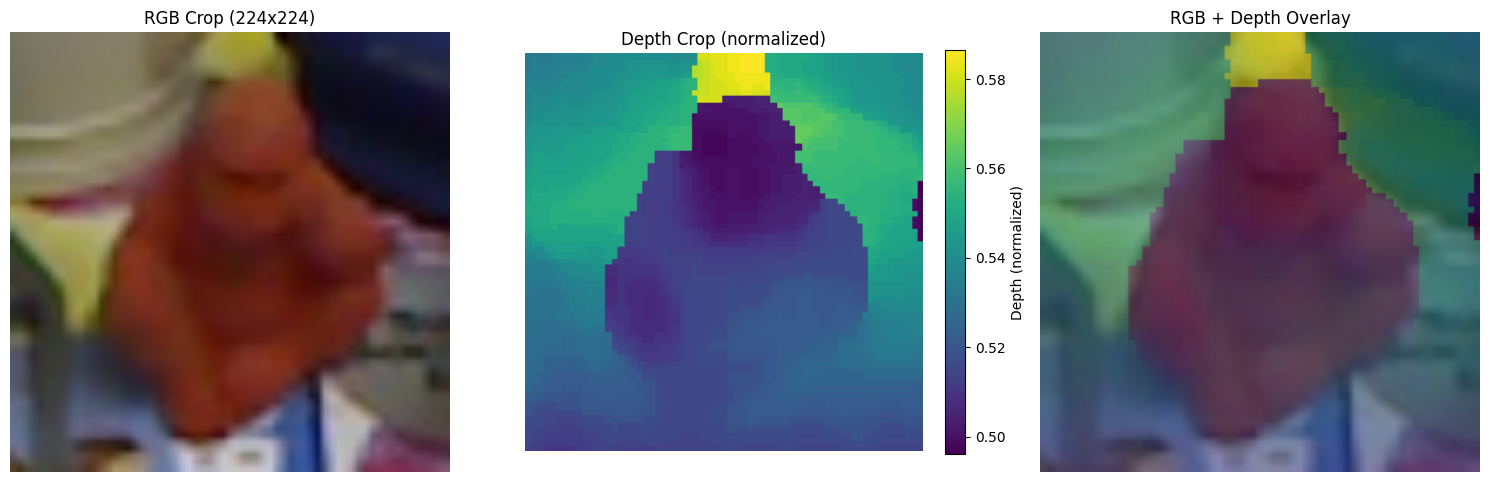


✅ Step 2 completed: ROI crops for RGB and Depth


In [50]:
# Visualize the crops
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB crop
axes[0].imshow(rgb_crop)
axes[0].set_title(f'RGB Crop ({rgb_crop.shape[0]}x{rgb_crop.shape[1]})')
axes[0].axis('off')

# Depth crop (normalized for visualization)
im = axes[1].imshow(depth_crop_normalized, cmap='viridis')
axes[1].set_title(f'Depth Crop (normalized)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, label='Depth (normalized)')

# RGB + Depth overlay
axes[2].imshow(rgb_crop)
axes[2].imshow(depth_crop_normalized, cmap='viridis', alpha=0.5)
axes[2].set_title('RGB + Depth Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Step 2 completed: ROI crops for RGB and Depth")

# Step 3: Feature Extraction

- **RGB Branch**: ResNet-18 backbone → 512-dim features
- **Depth Branch**: DepthEncoder CNN → 512-dim features (see `models/depth_encoder.py`)

In [51]:
# Feature extraction models
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from models.depth_encoder import DepthEncoder

# RGB Branch: ResNet-18 (pretrained, without final FC)
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
rgb_encoder = nn.Sequential(*list(resnet.children())[:-1]).to(Config.DEVICE)
rgb_encoder.eval()

# Depth Branch: DepthEncoder
depth_encoder = DepthEncoder(output_dim=512).to(Config.DEVICE)
depth_encoder.eval()

print(f"✅ Feature extractors loaded:")
print(f"   RGB: ResNet-18 → 512-dim")
print(f"   Depth: DepthEncoder → 512-dim")

✅ Feature extractors loaded:
   RGB: ResNet-18 → 512-dim
   Depth: DepthEncoder → 512-dim


In [52]:
# Prepare tensors
from torchvision import transforms
import torch.nn as nn

# ImageNet normalization for RGB
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# RGB tensor
rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
rgb_tensor = imagenet_normalize(rgb_tensor).unsqueeze(0).to(Config.DEVICE)

# Depth tensor
depth_tensor = torch.from_numpy(depth_crop_normalized).float().unsqueeze(0).unsqueeze(0).to(Config.DEVICE)

print(f"✅ Input tensors: RGB {rgb_tensor.shape}, Depth {depth_tensor.shape}")

✅ Input tensors: RGB torch.Size([1, 3, 224, 224]), Depth torch.Size([1, 1, 224, 224])


In [53]:
# Extract features
with torch.no_grad():
    f_rgb = rgb_encoder(rgb_tensor).squeeze()      # (512,)
    f_depth = depth_encoder(depth_tensor).squeeze() # (512,)

print(f"✅ Step 3 completed:")
print(f"   f_rgb: {f_rgb.shape}")
print(f"   f_depth: {f_depth.shape}")

✅ Step 3 completed:
   f_rgb: torch.Size([512])
   f_depth: torch.Size([512])


# Step 4: Fusion

Late fusion via concatenation:

$$f_{\text{fused}} = \text{concat}(f_{\text{rgb}}, f_{\text{depth}}) \in \mathbb{R}^{1024}$$

In [54]:
# Late fusion: concatenate RGB and Depth features
f_fused = torch.cat([f_rgb, f_depth], dim=0)

print(f"✅ Step 4 completed: Feature Fusion")
print(f"   f_rgb:   {f_rgb.shape[0]} dims")
print(f"   f_depth: {f_depth.shape[0]} dims")
print(f"   f_fused: {f_fused.shape[0]} dims (concatenated)")

✅ Step 4 completed: Feature Fusion
   f_rgb:   512 dims
   f_depth: 512 dims
   f_fused: 1024 dims (concatenated)


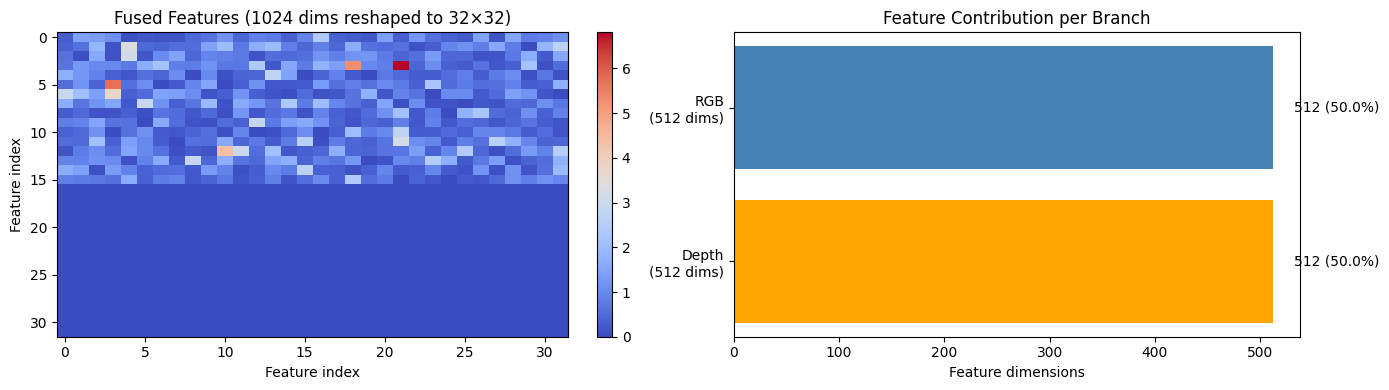

In [55]:
# Visualize fused feature vector
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Fused features as heatmap (reshaped for visualization)
f_np = f_fused.cpu().numpy()
# Reshape to 2D for better visualization (32x32 = 1024)
f_2d = f_np.reshape(32, 32)
im = axes[0].imshow(f_2d, cmap='coolwarm', aspect='auto')
axes[0].set_title(f'Fused Features (1024 dims reshaped to 32×32)')
axes[0].set_xlabel('Feature index')
axes[0].set_ylabel('Feature index')
plt.colorbar(im, ax=axes[0], fraction=0.046)

# Show contribution of each branch
axes[1].barh(['Depth\n(512 dims)', 'RGB\n(512 dims)'], [512, 512], color=['orange', 'steelblue'])
axes[1].set_xlabel('Feature dimensions')
axes[1].set_title('Feature Contribution per Branch')
for i, v in enumerate([512, 512]):
    axes[1].text(v + 20, i, f'{v} ({v/1024*100:.1f}%)', va='center')

plt.tight_layout()
plt.show()

# Step 5: Pose Estimation

MLP regressor predicts 6D pose from fused features:
- **Quaternion** (4D): $[q_w, q_x, q_y, q_z]$ normalized to unit norm
- **Translation** (3D): $[t_x, t_y, t_z]$ in meters

Input: 1024-dim fused features (512 RGB + 512 Depth)

See `models/pose_regressor.py`

In [56]:
# Pose regressor
from models.pose_regressor import PoseRegressor

pose_regressor = PoseRegressor(input_dim=1024, dropout=0.3).to(Config.DEVICE)
pose_regressor.eval()

# Predict pose (model has random weights - just testing the pipeline)
with torch.no_grad():
    f_fused_batch = f_fused.unsqueeze(0)  # (1, 1024)
    pose_pred = pose_regressor(f_fused_batch).squeeze()  # (7,)

quat_pred = pose_pred[:4].cpu().numpy()
trans_pred = pose_pred[4:].cpu().numpy()

print(f"✅ Step 5 completed: Pose Estimation")
print(f"   Quaternion [qw,qx,qy,qz]: {quat_pred}")
print(f"   Quaternion norm: {np.linalg.norm(quat_pred):.6f}")
print(f"   Translation [tx,ty,tz]: {trans_pred}")

✅ Step 5 completed: Pose Estimation
   Quaternion [qw,qx,qy,qz]: [   -0.74466    -0.28632     -0.4999     0.33704]
   Quaternion norm: 1.000000
   Translation [tx,ty,tz]: [  -0.036927    0.015026   -0.022988]


In [57]:
# Compare with ground truth
gt_quat = sample['quaternion'].numpy()
gt_trans = sample['translation'].numpy()

print(f"📊 Comparison (random weights vs GT):")
print(f"   Predicted quat: {quat_pred}")
print(f"   GT quat:        {gt_quat}")
print(f"   Predicted trans: {trans_pred}")
print(f"   GT trans:        {gt_trans}")

print(f"\n🎉 Pipeline complete! Next: train the model on LineMOD dataset.")

📊 Comparison (random weights vs GT):
   Predicted quat: [   -0.74466    -0.28632     -0.4999     0.33704]
   GT quat:        [    0.32371      0.6706     0.61941    -0.24869]
   Predicted trans: [  -0.036927    0.015026   -0.022988]
   GT trans:        [   -0.10359   -0.049804      1.0251]

🎉 Pipeline complete! Next: train the model on LineMOD dataset.


# Step 6: Training

Train the complete RGB-D fusion model end-to-end:
- **RGB Encoder**: ResNet-18 (pretrained, fine-tuned)
- **Depth Encoder**: DepthEncoder (trained from scratch)
- **Pose Regressor**: MLP (trained from scratch)

Loss: Geodesic (rotation) + Smooth L1 (translation)

In [80]:
# Training configuration
TRAIN_CONFIG = {
    'epochs': 25,
    'batch_size': 64,
    'lr': 1e-5,
    'weight_decay': 1e-5,
    'lambda_rot': 20.0,    # Bilanciato con translation (loss_rot ~ 0.5 rad)
    'lambda_trans': 1.0,   # loss_trans già scalata ×1000 in PoseLoss
}

print(f"📋 Training configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"   {k}: {v}")

📋 Training configuration:
   epochs: 25
   batch_size: 64
   lr: 1e-05
   weight_decay: 1e-05
   lambda_rot: 20.0
   lambda_trans: 1.0


Integration of camera related data (K-intrinsics and bbox location)
This ensures that no data is lost.

In [59]:
import torch

def build_crop_meta(bbox_xywh: torch.Tensor, cam_K: torch.Tensor, img_h: int, img_w: int) -> torch.Tensor:
    """
    Build scalar metadata for translation disambiguation.

    bbox_xywh: (4,) [x, y, w, h] in pixels (original image)
    cam_K: (3,3)
    returns: (10,) float tensor
    """
    # English comments as requested
    x, y, w, h = bbox_xywh.float()
    W = float(img_w)
    H = float(img_h)

    # BBox center in original image coordinates (normalized)
    uc = (x + 0.5 * w) / (W + 1e-6)
    vc = (y + 0.5 * h) / (H + 1e-6)

    # BBox size (normalized)
    wn = w / (W + 1e-6)
    hn = h / (H + 1e-6)
    area_n = (w * h) / ((W * H) + 1e-6)
    ar = w / (h + 1e-6)

    fx = cam_K[0, 0].float()
    fy = cam_K[1, 1].float()
    cx = cam_K[0, 2].float()
    cy = cam_K[1, 2].float()

    # Normalize intrinsics to image size
    fx_n = fx / (W + 1e-6)
    fy_n = fy / (H + 1e-6)
    cx_n = cx / (W + 1e-6)
    cy_n = cy / (H + 1e-6)

    meta = torch.stack([uc, vc, wn, hn, area_n, ar, fx_n, fy_n, cx_n, cy_n], dim=0)
    return meta


In [64]:
# Custom Dataset for RGB-D fusion training
from torch.utils.data import Dataset, DataLoader, random_split

class LineMODFusionDataset(Dataset):
    """Dataset that returns RGB crop, Depth crop, and pose labels."""
    
    def __init__(self, base_dataset, crop_margin=0.15, output_size=224, depth_max=2000.0):
        self.base_dataset = base_dataset
        self.crop_margin = crop_margin
        self.output_size = output_size
        self.depth_max = depth_max
        self.imagenet_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        
        # Load full images
        rgb_full = cv2.cvtColor(cv2.imread(sample['rgb_path']), cv2.COLOR_BGR2RGB)
        depth_full = np.array(Image.open(sample['depth_path']))
        
        # Get bbox (convert from [x,y,w,h] to [x1,y1,x2,y2])
        bbox = sample['bbox'].numpy()
        x, y, w, h = bbox
        bbox_xyxy = np.array([x, y, x+w, y+h])
        
        # Crop both RGB and Depth at same coordinates
        rgb_crop = crop_roi(rgb_full, bbox_xyxy, self.crop_margin, self.output_size)
        depth_crop = crop_roi(depth_full, bbox_xyxy, self.crop_margin, self.output_size)
        
        # Normalize depth to [0, 1]
        depth_crop = np.clip(depth_crop / self.depth_max, 0, 1).astype(np.float32)
        
        # Convert RGB to tensor and normalize
        rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
        rgb_tensor = self.imagenet_normalize(rgb_tensor)
        
        # Convert depth to tensor
        depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0).float()
        
        # Convert obj_id to tensor for proper batching
        obj_id = sample['obj_id'] #if sample['obj_id'] is not None else -1

        
        img_h, img_w = sample['rgb'].shape[-2], sample['rgb'].shape[-1]  # if 'rgb' is [C,H,W]
        meta = build_crop_meta(sample['bbox'], sample['cam_K'], img_h, img_w)
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'quaternion': sample['quaternion'],
            'translation': sample['translation'],
            'obj_id': torch.tensor(obj_id, dtype=torch.long),
            'meta': meta
        }

# Create dataloaders
full_train = LineMODPoseDataset(Config.LINEMOD_ROOT, split='train')
full_test = LineMODPoseDataset(Config.LINEMOD_ROOT, split='test')

# Train/val split
train_len = int(len(full_train) * 0.85)
val_len = len(full_train) - train_len
train_base, val_base = random_split(full_train, [train_len, val_len], 
                                     generator=torch.Generator().manual_seed(42))

train_dataset = LineMODFusionDataset(train_base)
val_dataset = LineMODFusionDataset(val_base)
test_dataset_fusion = LineMODFusionDataset(full_test)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset_fusion)} samples")

✅ Datasets created:
   Train: 11395 samples
   Val: 2012 samples
   Test: 2373 samples


In [65]:
# Initialize fresh models for training
rgb_encoder_train = nn.Sequential(*list(models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).children())[:-1])
depth_encoder_train = DepthEncoder(output_dim=512)
pose_regressor_train = PoseRegressor(input_dim=1034, dropout=0.3) #1024+meta10

# Move to device
rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
pose_regressor_train = pose_regressor_train.to(Config.DEVICE)

# Optimizer (all parameters)
all_params = list(rgb_encoder_train.parameters()) + \
             list(depth_encoder_train.parameters()) + \
             list(pose_regressor_train.parameters())

optimizer = torch.optim.AdamW(all_params, lr=TRAIN_CONFIG['lr'], weight_decay=TRAIN_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAIN_CONFIG['epochs'])

# Loss functions
from utils.losses import PoseLoss
criterion = PoseLoss(lambda_trans=TRAIN_CONFIG['lambda_trans'], lambda_rot=TRAIN_CONFIG['lambda_rot'])

print(f"✅ Models and optimizer initialized")
print(f"   Total parameters: {sum(p.numel() for p in all_params):,}")

✅ PoseLoss initialized
   λ_trans: 1.0
   λ_rot: 20.0
✅ Models and optimizer initialized
   Total parameters: 14,469,127


In [66]:
# Training loop
from tqdm.auto import tqdm

def train_epoch(rgb_enc, depth_enc, pose_reg, loader, optimizer, criterion, device, log_interval=100):
    rgb_enc.train()
    depth_enc.train()
    pose_reg.train()
    
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(loader, desc="Training", leave=False)):
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        gt_quat = batch['quaternion'].to(device)
        gt_trans = batch['translation'].to(device)
        meta = batch['meta'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_enc(depth)
        f_fused = torch.cat([f_rgb, f_depth, meta], dim=1)
        pose = pose_reg(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # Loss (PoseLoss returns a dict with 'total', 'rot', 'trans')
        loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
        loss = loss_dict['total']
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 📊 Logging per verificare bilanciamento loss
        if batch_idx % log_interval == 0:
            weighted_trans = criterion.lambda_trans * loss_dict['trans'].item()
            weighted_rot = criterion.lambda_rot * loss_dict['rot'].item()
            tqdm.write(f"   [Batch {batch_idx}] loss_trans: {loss_dict['trans'].item():.4f} (×{criterion.lambda_trans}={weighted_trans:.4f}) | "
                      f"loss_rot: {loss_dict['rot'].item():.4f} (×{criterion.lambda_rot}={weighted_rot:.4f}) | "
                      f"ratio: {weighted_trans/(weighted_rot+1e-8):.2f}")
    
    return total_loss / len(loader)

def validate_epoch(rgb_enc, depth_enc, pose_reg, loader, criterion, device):
    rgb_enc.eval()
    depth_enc.eval()
    pose_reg.eval()
    
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            gt_quat = batch['quaternion'].to(device)
            gt_trans = batch['translation'].to(device)
            meta = batch['meta'].to(device)
            
            f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
            f_depth = depth_enc(depth)
            f_fused = torch.cat([f_rgb, f_depth, meta], dim=1)
            pose = pose_reg(f_fused)
            
            pred_quat = pose[:, :4]
            pred_trans = pose[:, 4:]
            
            loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
            loss = loss_dict['total']
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("✅ Training functions defined")

✅ Training functions defined


In [67]:
# Run training
train_losses = []
val_losses = []
best_val_loss = float('inf')

checkpoint_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"🚀 Starting training for {TRAIN_CONFIG['epochs']} epochs...")
print(f"   Checkpoint dir: {checkpoint_dir}")

for epoch in range(TRAIN_CONFIG['epochs']):
    train_loss = train_epoch(
        rgb_encoder_train, depth_encoder_train, pose_regressor_train,
        train_loader, optimizer, criterion, Config.DEVICE
    )
    val_loss = validate_epoch(
        rgb_encoder_train, depth_encoder_train, pose_regressor_train,
        val_loader, criterion, Config.DEVICE
    )
    
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'rgb_encoder': rgb_encoder_train.state_dict(),
            'depth_encoder': depth_encoder_train.state_dict(),
            'pose_regressor': pose_regressor_train.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_dir / 'best.pt')
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} ⭐ (best)")
    else:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

print(f"\n✅ Training complete! Best val loss: {best_val_loss:.4f}")

🚀 Starting training for 30 epochs...
   Checkpoint dir: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512


Training:   0%|          | 1/713 [00:01<13:48,  1.16s/it]

   [Batch 0] loss_trans: 125.0798 (×1.0=125.0798) | loss_rot: 1.0104 (×20.0=20.2090) | ratio: 6.19


Training:   7%|▋         | 51/713 [00:18<03:57,  2.78it/s]

   [Batch 50] loss_trans: 102.4213 (×1.0=102.4213) | loss_rot: 0.9285 (×20.0=18.5701) | ratio: 5.52


Training:  14%|█▍        | 101/713 [00:36<03:32,  2.89it/s]

   [Batch 100] loss_trans: 136.0929 (×1.0=136.0929) | loss_rot: 0.9259 (×20.0=18.5188) | ratio: 7.35


Training:  21%|██        | 151/713 [00:54<03:23,  2.75it/s]

   [Batch 150] loss_trans: 84.5857 (×1.0=84.5857) | loss_rot: 1.2079 (×20.0=24.1571) | ratio: 3.50


Training:  28%|██▊       | 201/713 [01:12<02:49,  3.02it/s]

   [Batch 200] loss_trans: 125.6166 (×1.0=125.6166) | loss_rot: 1.0039 (×20.0=20.0786) | ratio: 6.26


Training:  35%|███▌      | 251/713 [01:30<02:47,  2.77it/s]

   [Batch 250] loss_trans: 92.9937 (×1.0=92.9937) | loss_rot: 0.9468 (×20.0=18.9369) | ratio: 4.91


Training:  42%|████▏     | 301/713 [01:48<02:25,  2.84it/s]

   [Batch 300] loss_trans: 97.2812 (×1.0=97.2812) | loss_rot: 0.9967 (×20.0=19.9338) | ratio: 4.88


Training:  49%|████▉     | 351/713 [02:06<02:16,  2.65it/s]

   [Batch 350] loss_trans: 90.4002 (×1.0=90.4002) | loss_rot: 0.9153 (×20.0=18.3060) | ratio: 4.94


Training:  56%|█████▌    | 401/713 [02:23<01:48,  2.87it/s]

   [Batch 400] loss_trans: 66.3826 (×1.0=66.3826) | loss_rot: 0.9443 (×20.0=18.8869) | ratio: 3.51


Training:  63%|██████▎   | 451/713 [02:41<01:32,  2.83it/s]

   [Batch 450] loss_trans: 62.5803 (×1.0=62.5803) | loss_rot: 0.9399 (×20.0=18.7973) | ratio: 3.33


Training:  70%|███████   | 501/713 [03:00<01:22,  2.58it/s]

   [Batch 500] loss_trans: 67.2294 (×1.0=67.2294) | loss_rot: 0.9270 (×20.0=18.5393) | ratio: 3.63


Training:  77%|███████▋  | 551/713 [03:18<00:55,  2.91it/s]

   [Batch 550] loss_trans: 67.4438 (×1.0=67.4438) | loss_rot: 0.9370 (×20.0=18.7401) | ratio: 3.60


Training:  84%|████████▍ | 601/713 [03:36<00:39,  2.84it/s]

   [Batch 600] loss_trans: 50.1078 (×1.0=50.1078) | loss_rot: 0.9858 (×20.0=19.7159) | ratio: 2.54


Training:  91%|█████████▏| 651/713 [03:53<00:22,  2.79it/s]

   [Batch 650] loss_trans: 58.9746 (×1.0=58.9746) | loss_rot: 0.8362 (×20.0=16.7232) | ratio: 3.53


Training:  98%|█████████▊| 701/713 [04:11<00:04,  2.63it/s]

   [Batch 700] loss_trans: 42.1922 (×1.0=42.1922) | loss_rot: 0.8476 (×20.0=16.9521) | ratio: 2.49


Epoch   1 | Train: 102.1557 | Val: 51.3290 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:26,  3.44it/s]

   [Batch 0] loss_trans: 62.7216 (×1.0=62.7216) | loss_rot: 0.9267 (×20.0=18.5337) | ratio: 3.38


Training:   7%|▋         | 51/713 [00:17<03:44,  2.95it/s]

   [Batch 50] loss_trans: 42.2989 (×1.0=42.2989) | loss_rot: 0.7175 (×20.0=14.3502) | ratio: 2.95


Training:  14%|█▍        | 101/713 [00:33<03:29,  2.92it/s]

   [Batch 100] loss_trans: 53.2298 (×1.0=53.2298) | loss_rot: 0.8625 (×20.0=17.2493) | ratio: 3.09


Training:  21%|██        | 151/713 [00:50<03:02,  3.08it/s]

   [Batch 150] loss_trans: 44.7172 (×1.0=44.7172) | loss_rot: 0.9652 (×20.0=19.3047) | ratio: 2.32


Training:  28%|██▊       | 201/713 [01:07<02:51,  2.98it/s]

   [Batch 200] loss_trans: 64.3429 (×1.0=64.3429) | loss_rot: 0.8663 (×20.0=17.3266) | ratio: 3.71


Training:  35%|███▌      | 251/713 [01:24<02:28,  3.11it/s]

   [Batch 250] loss_trans: 38.5099 (×1.0=38.5099) | loss_rot: 1.0096 (×20.0=20.1917) | ratio: 1.91


Training:  42%|████▏     | 301/713 [01:41<02:24,  2.86it/s]

   [Batch 300] loss_trans: 41.8522 (×1.0=41.8522) | loss_rot: 0.6604 (×20.0=13.2083) | ratio: 3.17


Training:  49%|████▉     | 351/713 [01:58<02:09,  2.79it/s]

   [Batch 350] loss_trans: 44.5628 (×1.0=44.5628) | loss_rot: 0.7726 (×20.0=15.4528) | ratio: 2.88


Training:  56%|█████▌    | 401/713 [02:15<01:43,  3.01it/s]

   [Batch 400] loss_trans: 51.6106 (×1.0=51.6106) | loss_rot: 0.8971 (×20.0=17.9414) | ratio: 2.88


Training:  63%|██████▎   | 451/713 [02:32<01:32,  2.83it/s]

   [Batch 450] loss_trans: 41.8981 (×1.0=41.8981) | loss_rot: 0.8902 (×20.0=17.8043) | ratio: 2.35


Training:  70%|███████   | 501/713 [02:48<01:08,  3.09it/s]

   [Batch 500] loss_trans: 35.7999 (×1.0=35.7999) | loss_rot: 0.9230 (×20.0=18.4592) | ratio: 1.94


Training:  77%|███████▋  | 551/713 [03:05<00:56,  2.87it/s]

   [Batch 550] loss_trans: 32.7467 (×1.0=32.7467) | loss_rot: 1.0348 (×20.0=20.6961) | ratio: 1.58


Training:  84%|████████▍ | 601/713 [03:22<00:37,  2.95it/s]

   [Batch 600] loss_trans: 60.0533 (×1.0=60.0533) | loss_rot: 0.9470 (×20.0=18.9398) | ratio: 3.17


Training:  91%|█████████▏| 651/713 [03:39<00:21,  2.90it/s]

   [Batch 650] loss_trans: 53.9503 (×1.0=53.9503) | loss_rot: 0.8349 (×20.0=16.6986) | ratio: 3.23


Training:  98%|█████████▊| 701/713 [03:56<00:04,  2.87it/s]

   [Batch 700] loss_trans: 64.8467 (×1.0=64.8467) | loss_rot: 0.8548 (×20.0=17.0960) | ratio: 3.79


Epoch   2 | Train: 65.2632 | Val: 37.2111 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:02,  3.91it/s]

   [Batch 0] loss_trans: 43.1034 (×1.0=43.1034) | loss_rot: 0.9502 (×20.0=19.0037) | ratio: 2.27


Training:   7%|▋         | 51/713 [00:17<03:39,  3.01it/s]

   [Batch 50] loss_trans: 56.3812 (×1.0=56.3812) | loss_rot: 0.9178 (×20.0=18.3555) | ratio: 3.07


Training:  14%|█▍        | 101/713 [00:34<03:21,  3.04it/s]

   [Batch 100] loss_trans: 41.5993 (×1.0=41.5993) | loss_rot: 0.8143 (×20.0=16.2868) | ratio: 2.55


Training:  21%|██        | 151/713 [00:51<03:13,  2.91it/s]

   [Batch 150] loss_trans: 26.8394 (×1.0=26.8394) | loss_rot: 0.8336 (×20.0=16.6710) | ratio: 1.61


Training:  28%|██▊       | 201/713 [01:08<02:51,  2.98it/s]

   [Batch 200] loss_trans: 29.8573 (×1.0=29.8573) | loss_rot: 0.7079 (×20.0=14.1571) | ratio: 2.11


Training:  35%|███▌      | 251/713 [01:24<02:26,  3.15it/s]

   [Batch 250] loss_trans: 34.4938 (×1.0=34.4938) | loss_rot: 0.8274 (×20.0=16.5476) | ratio: 2.08


Training:  42%|████▏     | 301/713 [01:41<02:11,  3.13it/s]

   [Batch 300] loss_trans: 32.3050 (×1.0=32.3050) | loss_rot: 0.7685 (×20.0=15.3697) | ratio: 2.10


Training:  49%|████▉     | 351/713 [01:58<02:02,  2.96it/s]

   [Batch 350] loss_trans: 27.2675 (×1.0=27.2675) | loss_rot: 0.7636 (×20.0=15.2725) | ratio: 1.79


Training:  56%|█████▌    | 401/713 [02:15<01:45,  2.95it/s]

   [Batch 400] loss_trans: 46.9076 (×1.0=46.9076) | loss_rot: 0.8751 (×20.0=17.5025) | ratio: 2.68


Training:  63%|██████▎   | 451/713 [02:33<01:32,  2.83it/s]

   [Batch 450] loss_trans: 39.9654 (×1.0=39.9654) | loss_rot: 1.0080 (×20.0=20.1599) | ratio: 1.98


Training:  70%|███████   | 501/713 [02:49<01:10,  3.00it/s]

   [Batch 500] loss_trans: 30.6203 (×1.0=30.6203) | loss_rot: 0.6655 (×20.0=13.3102) | ratio: 2.30


Training:  77%|███████▋  | 551/713 [03:06<00:54,  2.96it/s]

   [Batch 550] loss_trans: 32.4529 (×1.0=32.4529) | loss_rot: 0.8208 (×20.0=16.4165) | ratio: 1.98


Training:  84%|████████▍ | 601/713 [03:23<00:36,  3.05it/s]

   [Batch 600] loss_trans: 47.3258 (×1.0=47.3258) | loss_rot: 0.8449 (×20.0=16.8984) | ratio: 2.80


Training:  91%|█████████▏| 651/713 [03:40<00:20,  2.99it/s]

   [Batch 650] loss_trans: 31.7537 (×1.0=31.7537) | loss_rot: 0.7121 (×20.0=14.2428) | ratio: 2.23


Training:  98%|█████████▊| 701/713 [03:56<00:03,  3.07it/s]

   [Batch 700] loss_trans: 23.9404 (×1.0=23.9404) | loss_rot: 0.9840 (×20.0=19.6803) | ratio: 1.22


Epoch   3 | Train: 53.6886 | Val: 32.7907 ⭐ (best)


Training:   0%|          | 1/713 [00:00<07:34,  1.57it/s]

   [Batch 0] loss_trans: 41.4071 (×1.0=41.4071) | loss_rot: 0.8950 (×20.0=17.8991) | ratio: 2.31


Training:   7%|▋         | 51/713 [00:17<03:37,  3.04it/s]

   [Batch 50] loss_trans: 41.3092 (×1.0=41.3092) | loss_rot: 0.7673 (×20.0=15.3451) | ratio: 2.69


Training:  14%|█▍        | 101/713 [00:34<03:33,  2.87it/s]

   [Batch 100] loss_trans: 35.4996 (×1.0=35.4996) | loss_rot: 0.8059 (×20.0=16.1172) | ratio: 2.20


Training:  21%|██        | 151/713 [00:51<03:11,  2.93it/s]

   [Batch 150] loss_trans: 28.9127 (×1.0=28.9127) | loss_rot: 0.6259 (×20.0=12.5178) | ratio: 2.31


Training:  28%|██▊       | 201/713 [01:07<02:55,  2.92it/s]

   [Batch 200] loss_trans: 44.8805 (×1.0=44.8805) | loss_rot: 0.7405 (×20.0=14.8105) | ratio: 3.03


Training:  35%|███▌      | 251/713 [01:24<02:37,  2.94it/s]

   [Batch 250] loss_trans: 21.7956 (×1.0=21.7956) | loss_rot: 1.1358 (×20.0=22.7166) | ratio: 0.96


Training:  42%|████▏     | 301/713 [01:41<02:17,  3.00it/s]

   [Batch 300] loss_trans: 31.6811 (×1.0=31.6811) | loss_rot: 1.0096 (×20.0=20.1914) | ratio: 1.57


Training:  49%|████▉     | 351/713 [01:58<01:55,  3.13it/s]

   [Batch 350] loss_trans: 27.9708 (×1.0=27.9708) | loss_rot: 0.5882 (×20.0=11.7632) | ratio: 2.38


Training:  56%|█████▌    | 401/713 [02:15<01:49,  2.85it/s]

   [Batch 400] loss_trans: 23.7850 (×1.0=23.7850) | loss_rot: 0.9280 (×20.0=18.5603) | ratio: 1.28


Training:  63%|██████▎   | 451/713 [02:31<01:28,  2.97it/s]

   [Batch 450] loss_trans: 29.4097 (×1.0=29.4097) | loss_rot: 0.8330 (×20.0=16.6599) | ratio: 1.77


Training:  70%|███████   | 501/713 [02:48<01:12,  2.91it/s]

   [Batch 500] loss_trans: 27.0552 (×1.0=27.0552) | loss_rot: 0.7114 (×20.0=14.2278) | ratio: 1.90


Training:  77%|███████▋  | 551/713 [03:05<00:55,  2.93it/s]

   [Batch 550] loss_trans: 33.0563 (×1.0=33.0563) | loss_rot: 0.6960 (×20.0=13.9196) | ratio: 2.37


Training:  84%|████████▍ | 601/713 [03:22<00:37,  3.02it/s]

   [Batch 600] loss_trans: 25.4124 (×1.0=25.4124) | loss_rot: 0.8320 (×20.0=16.6397) | ratio: 1.53


Training:  91%|█████████▏| 651/713 [03:39<00:21,  2.87it/s]

   [Batch 650] loss_trans: 28.6806 (×1.0=28.6806) | loss_rot: 0.9075 (×20.0=18.1505) | ratio: 1.58


Training:  98%|█████████▊| 701/713 [03:56<00:03,  3.10it/s]

   [Batch 700] loss_trans: 28.3605 (×1.0=28.3605) | loss_rot: 0.8051 (×20.0=16.1018) | ratio: 1.76


Epoch   4 | Train: 48.3695 | Val: 29.2252 ⭐ (best)


Training:   0%|          | 1/713 [00:00<05:30,  2.16it/s]

   [Batch 0] loss_trans: 24.6882 (×1.0=24.6882) | loss_rot: 0.7705 (×20.0=15.4108) | ratio: 1.60


Training:   7%|▋         | 51/713 [00:16<03:44,  2.95it/s]

   [Batch 50] loss_trans: 41.4803 (×1.0=41.4803) | loss_rot: 0.8089 (×20.0=16.1783) | ratio: 2.56


Training:  14%|█▍        | 101/713 [00:33<03:28,  2.93it/s]

   [Batch 100] loss_trans: 34.1299 (×1.0=34.1299) | loss_rot: 0.7971 (×20.0=15.9421) | ratio: 2.14


Training:  21%|██        | 151/713 [00:50<03:16,  2.85it/s]

   [Batch 150] loss_trans: 35.6051 (×1.0=35.6051) | loss_rot: 0.8550 (×20.0=17.1006) | ratio: 2.08


Training:  28%|██▊       | 201/713 [01:07<02:55,  2.92it/s]

   [Batch 200] loss_trans: 20.7953 (×1.0=20.7953) | loss_rot: 0.7939 (×20.0=15.8773) | ratio: 1.31


Training:  35%|███▌      | 251/713 [01:24<02:35,  2.97it/s]

   [Batch 250] loss_trans: 18.5690 (×1.0=18.5690) | loss_rot: 0.8637 (×20.0=17.2743) | ratio: 1.07


Training:  42%|████▏     | 301/713 [01:41<02:28,  2.77it/s]

   [Batch 300] loss_trans: 24.8407 (×1.0=24.8407) | loss_rot: 0.7564 (×20.0=15.1284) | ratio: 1.64


Training:  49%|████▉     | 351/713 [01:58<01:44,  3.48it/s]

   [Batch 350] loss_trans: 38.5325 (×1.0=38.5325) | loss_rot: 0.9358 (×20.0=18.7158) | ratio: 2.06


Training:  56%|█████▌    | 401/713 [02:15<01:47,  2.89it/s]

   [Batch 400] loss_trans: 34.8617 (×1.0=34.8617) | loss_rot: 0.6694 (×20.0=13.3887) | ratio: 2.60


Training:  63%|██████▎   | 451/713 [02:32<01:27,  3.00it/s]

   [Batch 450] loss_trans: 34.5290 (×1.0=34.5290) | loss_rot: 0.7680 (×20.0=15.3594) | ratio: 2.25


Training:  70%|███████   | 501/713 [02:49<01:16,  2.78it/s]

   [Batch 500] loss_trans: 27.8997 (×1.0=27.8997) | loss_rot: 0.8002 (×20.0=16.0036) | ratio: 1.74


Training:  77%|███████▋  | 551/713 [03:06<00:54,  2.96it/s]

   [Batch 550] loss_trans: 27.4888 (×1.0=27.4888) | loss_rot: 0.7468 (×20.0=14.9369) | ratio: 1.84


Training:  84%|████████▍ | 601/713 [03:22<00:37,  3.00it/s]

   [Batch 600] loss_trans: 27.9084 (×1.0=27.9084) | loss_rot: 0.9183 (×20.0=18.3668) | ratio: 1.52


Training:  91%|█████████▏| 651/713 [03:39<00:20,  3.07it/s]

   [Batch 650] loss_trans: 24.1052 (×1.0=24.1052) | loss_rot: 0.9109 (×20.0=18.2184) | ratio: 1.32


Training:  98%|█████████▊| 701/713 [03:56<00:04,  2.98it/s]

   [Batch 700] loss_trans: 27.3306 (×1.0=27.3306) | loss_rot: 0.7195 (×20.0=14.3907) | ratio: 1.90


Epoch   5 | Train: 43.6951 | Val: 26.6506 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:04,  1.96it/s]

   [Batch 0] loss_trans: 24.5953 (×1.0=24.5953) | loss_rot: 0.7954 (×20.0=15.9072) | ratio: 1.55


Training:   7%|▋         | 51/713 [00:16<03:41,  2.99it/s]

   [Batch 50] loss_trans: 30.0707 (×1.0=30.0707) | loss_rot: 0.9515 (×20.0=19.0304) | ratio: 1.58


Training:  14%|█▍        | 101/713 [00:33<03:24,  2.99it/s]

   [Batch 100] loss_trans: 21.1420 (×1.0=21.1420) | loss_rot: 0.7968 (×20.0=15.9351) | ratio: 1.33


Training:  21%|██        | 151/713 [00:50<02:59,  3.12it/s]

   [Batch 150] loss_trans: 18.5692 (×1.0=18.5692) | loss_rot: 0.6941 (×20.0=13.8811) | ratio: 1.34


Training:  28%|██▊       | 201/713 [01:07<02:48,  3.03it/s]

   [Batch 200] loss_trans: 35.6233 (×1.0=35.6233) | loss_rot: 0.6947 (×20.0=13.8930) | ratio: 2.56


Training:  35%|███▌      | 251/713 [01:23<02:30,  3.06it/s]

   [Batch 250] loss_trans: 28.5152 (×1.0=28.5152) | loss_rot: 0.7514 (×20.0=15.0271) | ratio: 1.90


Training:  42%|████▏     | 301/713 [01:40<02:23,  2.86it/s]

   [Batch 300] loss_trans: 37.1908 (×1.0=37.1908) | loss_rot: 0.7928 (×20.0=15.8566) | ratio: 2.35


Training:  49%|████▉     | 351/713 [01:58<02:07,  2.84it/s]

   [Batch 350] loss_trans: 13.7971 (×1.0=13.7971) | loss_rot: 0.7369 (×20.0=14.7381) | ratio: 0.94


Training:  56%|█████▌    | 401/713 [02:16<01:55,  2.71it/s]

   [Batch 400] loss_trans: 23.5599 (×1.0=23.5599) | loss_rot: 0.8629 (×20.0=17.2585) | ratio: 1.37


Training:  63%|██████▎   | 451/713 [02:35<01:43,  2.54it/s]

   [Batch 450] loss_trans: 30.5270 (×1.0=30.5270) | loss_rot: 0.6659 (×20.0=13.3175) | ratio: 2.29


Training:  70%|███████   | 501/713 [02:54<01:15,  2.80it/s]

   [Batch 500] loss_trans: 28.1953 (×1.0=28.1953) | loss_rot: 0.8338 (×20.0=16.6759) | ratio: 1.69


Training:  77%|███████▋  | 551/713 [03:13<00:56,  2.84it/s]

   [Batch 550] loss_trans: 18.6823 (×1.0=18.6823) | loss_rot: 0.7280 (×20.0=14.5608) | ratio: 1.28


Training:  84%|████████▍ | 601/713 [03:31<00:40,  2.78it/s]

   [Batch 600] loss_trans: 22.8354 (×1.0=22.8354) | loss_rot: 0.8143 (×20.0=16.2858) | ratio: 1.40


Training:  91%|█████████▏| 651/713 [03:49<00:22,  2.73it/s]

   [Batch 650] loss_trans: 35.7366 (×1.0=35.7366) | loss_rot: 0.6454 (×20.0=12.9073) | ratio: 2.77


Training:  98%|█████████▊| 701/713 [04:08<00:04,  2.64it/s]

   [Batch 700] loss_trans: 13.7501 (×1.0=13.7501) | loss_rot: 0.6673 (×20.0=13.3462) | ratio: 1.03


Epoch   6 | Train: 39.9458 | Val: 23.2922 ⭐ (best)


Training:   0%|          | 1/713 [00:00<05:58,  1.99it/s]

   [Batch 0] loss_trans: 27.1292 (×1.0=27.1292) | loss_rot: 0.7761 (×20.0=15.5226) | ratio: 1.75


Training:   7%|▋         | 51/713 [00:18<03:46,  2.92it/s]

   [Batch 50] loss_trans: 19.1937 (×1.0=19.1937) | loss_rot: 0.5816 (×20.0=11.6317) | ratio: 1.65


Training:  14%|█▍        | 101/713 [00:36<03:32,  2.88it/s]

   [Batch 100] loss_trans: 22.5313 (×1.0=22.5313) | loss_rot: 0.6823 (×20.0=13.6450) | ratio: 1.65


Training:  21%|██        | 151/713 [00:55<03:44,  2.50it/s]

   [Batch 150] loss_trans: 20.2009 (×1.0=20.2009) | loss_rot: 0.7175 (×20.0=14.3505) | ratio: 1.41


Training:  28%|██▊       | 201/713 [01:13<02:56,  2.89it/s]

   [Batch 200] loss_trans: 16.6141 (×1.0=16.6141) | loss_rot: 0.7188 (×20.0=14.3757) | ratio: 1.16


Training:  35%|███▌      | 251/713 [01:31<02:47,  2.75it/s]

   [Batch 250] loss_trans: 13.6544 (×1.0=13.6544) | loss_rot: 0.6287 (×20.0=12.5744) | ratio: 1.09


Training:  42%|████▏     | 301/713 [01:50<02:32,  2.70it/s]

   [Batch 300] loss_trans: 24.7272 (×1.0=24.7272) | loss_rot: 0.5613 (×20.0=11.2267) | ratio: 2.20


Training:  49%|████▉     | 351/713 [02:08<02:18,  2.61it/s]

   [Batch 350] loss_trans: 24.8210 (×1.0=24.8210) | loss_rot: 0.5811 (×20.0=11.6219) | ratio: 2.14


Training:  56%|█████▌    | 401/713 [02:26<02:16,  2.29it/s]

   [Batch 400] loss_trans: 24.2696 (×1.0=24.2696) | loss_rot: 0.6462 (×20.0=12.9241) | ratio: 1.88


Training:  63%|██████▎   | 451/713 [02:43<01:37,  2.68it/s]

   [Batch 450] loss_trans: 16.8516 (×1.0=16.8516) | loss_rot: 0.8466 (×20.0=16.9317) | ratio: 1.00


Training:  70%|███████   | 501/713 [03:01<01:15,  2.82it/s]

   [Batch 500] loss_trans: 21.1531 (×1.0=21.1531) | loss_rot: 0.6066 (×20.0=12.1325) | ratio: 1.74


Training:  77%|███████▋  | 551/713 [03:18<00:52,  3.07it/s]

   [Batch 550] loss_trans: 19.1866 (×1.0=19.1866) | loss_rot: 0.7132 (×20.0=14.2640) | ratio: 1.35


Training:  84%|████████▍ | 601/713 [03:35<00:38,  2.91it/s]

   [Batch 600] loss_trans: 28.2561 (×1.0=28.2561) | loss_rot: 0.8452 (×20.0=16.9048) | ratio: 1.67


Training:  91%|█████████▏| 651/713 [03:52<00:21,  2.92it/s]

   [Batch 650] loss_trans: 18.7056 (×1.0=18.7056) | loss_rot: 0.6414 (×20.0=12.8279) | ratio: 1.46


Training:  98%|█████████▊| 701/713 [04:09<00:04,  2.95it/s]

   [Batch 700] loss_trans: 22.6414 (×1.0=22.6414) | loss_rot: 0.9844 (×20.0=19.6883) | ratio: 1.15


Epoch   7 | Train: 37.0504 | Val: 21.0363 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:24,  1.85it/s]

   [Batch 0] loss_trans: 25.4901 (×1.0=25.4901) | loss_rot: 0.7993 (×20.0=15.9860) | ratio: 1.59


Training:   7%|▋         | 51/713 [00:17<03:51,  2.86it/s]

   [Batch 50] loss_trans: 18.7150 (×1.0=18.7150) | loss_rot: 0.7372 (×20.0=14.7444) | ratio: 1.27


Training:  14%|█▍        | 101/713 [00:33<03:30,  2.90it/s]

   [Batch 100] loss_trans: 18.4322 (×1.0=18.4322) | loss_rot: 0.7479 (×20.0=14.9579) | ratio: 1.23


Training:  21%|██        | 151/713 [00:50<03:15,  2.88it/s]

   [Batch 150] loss_trans: 18.2989 (×1.0=18.2989) | loss_rot: 0.6556 (×20.0=13.1124) | ratio: 1.40


Training:  28%|██▊       | 201/713 [01:07<02:51,  2.99it/s]

   [Batch 200] loss_trans: 15.2500 (×1.0=15.2500) | loss_rot: 0.7171 (×20.0=14.3419) | ratio: 1.06


Training:  35%|███▌      | 251/713 [01:24<02:35,  2.97it/s]

   [Batch 250] loss_trans: 25.8764 (×1.0=25.8764) | loss_rot: 0.8044 (×20.0=16.0886) | ratio: 1.61


Training:  42%|████▏     | 301/713 [01:41<02:19,  2.95it/s]

   [Batch 300] loss_trans: 24.4105 (×1.0=24.4105) | loss_rot: 0.8534 (×20.0=17.0673) | ratio: 1.43


Training:  49%|████▉     | 351/713 [01:58<01:58,  3.05it/s]

   [Batch 350] loss_trans: 15.7505 (×1.0=15.7505) | loss_rot: 0.8005 (×20.0=16.0095) | ratio: 0.98


Training:  56%|█████▌    | 401/713 [02:15<01:54,  2.73it/s]

   [Batch 400] loss_trans: 12.6288 (×1.0=12.6288) | loss_rot: 0.7965 (×20.0=15.9299) | ratio: 0.79


Training:  63%|██████▎   | 451/713 [02:34<01:37,  2.68it/s]

   [Batch 450] loss_trans: 20.6121 (×1.0=20.6121) | loss_rot: 0.8245 (×20.0=16.4899) | ratio: 1.25


Training:  70%|███████   | 501/713 [02:53<01:16,  2.78it/s]

   [Batch 500] loss_trans: 20.2030 (×1.0=20.2030) | loss_rot: 0.8481 (×20.0=16.9622) | ratio: 1.19


Training:  77%|███████▋  | 551/713 [03:11<01:00,  2.69it/s]

   [Batch 550] loss_trans: 17.4115 (×1.0=17.4115) | loss_rot: 0.7807 (×20.0=15.6147) | ratio: 1.12


Training:  84%|████████▍ | 601/713 [03:30<00:41,  2.68it/s]

   [Batch 600] loss_trans: 24.1984 (×1.0=24.1984) | loss_rot: 0.7426 (×20.0=14.8516) | ratio: 1.63


Training:  91%|█████████▏| 651/713 [03:48<00:22,  2.78it/s]

   [Batch 650] loss_trans: 19.2918 (×1.0=19.2918) | loss_rot: 0.6087 (×20.0=12.1746) | ratio: 1.58


Training:  98%|█████████▊| 701/713 [04:07<00:04,  2.79it/s]

   [Batch 700] loss_trans: 21.7137 (×1.0=21.7137) | loss_rot: 0.6122 (×20.0=12.2446) | ratio: 1.77


Epoch   8 | Train: 34.8683 | Val: 19.6948 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:45,  1.75it/s]

   [Batch 0] loss_trans: 20.4636 (×1.0=20.4636) | loss_rot: 0.9121 (×20.0=18.2417) | ratio: 1.12


Training:   7%|▋         | 51/713 [00:17<03:50,  2.87it/s]

   [Batch 50] loss_trans: 18.1373 (×1.0=18.1373) | loss_rot: 0.7315 (×20.0=14.6306) | ratio: 1.24


Training:  14%|█▍        | 101/713 [00:34<03:39,  2.79it/s]

   [Batch 100] loss_trans: 22.7268 (×1.0=22.7268) | loss_rot: 0.7150 (×20.0=14.2998) | ratio: 1.59


Training:  21%|██        | 151/713 [00:51<03:10,  2.94it/s]

   [Batch 150] loss_trans: 18.8779 (×1.0=18.8779) | loss_rot: 0.6671 (×20.0=13.3416) | ratio: 1.41


Training:  28%|██▊       | 201/713 [01:08<02:52,  2.97it/s]

   [Batch 200] loss_trans: 13.0449 (×1.0=13.0449) | loss_rot: 0.7123 (×20.0=14.2458) | ratio: 0.92


Training:  35%|███▌      | 251/713 [01:25<02:28,  3.10it/s]

   [Batch 250] loss_trans: 20.9538 (×1.0=20.9538) | loss_rot: 0.6260 (×20.0=12.5198) | ratio: 1.67


Training:  42%|████▏     | 301/713 [01:41<02:19,  2.95it/s]

   [Batch 300] loss_trans: 16.9848 (×1.0=16.9848) | loss_rot: 0.7069 (×20.0=14.1386) | ratio: 1.20


Training:  49%|████▉     | 351/713 [01:58<02:02,  2.97it/s]

   [Batch 350] loss_trans: 14.7254 (×1.0=14.7254) | loss_rot: 0.6926 (×20.0=13.8523) | ratio: 1.06


Training:  56%|█████▌    | 401/713 [02:15<01:42,  3.04it/s]

   [Batch 400] loss_trans: 15.7733 (×1.0=15.7733) | loss_rot: 0.8127 (×20.0=16.2546) | ratio: 0.97


Training:  63%|██████▎   | 451/713 [02:32<01:26,  3.01it/s]

   [Batch 450] loss_trans: 12.6221 (×1.0=12.6221) | loss_rot: 0.7334 (×20.0=14.6683) | ratio: 0.86


Training:  70%|███████   | 501/713 [02:50<01:11,  2.96it/s]

   [Batch 500] loss_trans: 17.1293 (×1.0=17.1293) | loss_rot: 0.6128 (×20.0=12.2558) | ratio: 1.40


Training:  77%|███████▋  | 551/713 [03:07<00:55,  2.90it/s]

   [Batch 550] loss_trans: 14.0119 (×1.0=14.0119) | loss_rot: 0.6911 (×20.0=13.8230) | ratio: 1.01


Training:  84%|████████▍ | 601/713 [03:24<00:38,  2.91it/s]

   [Batch 600] loss_trans: 25.8689 (×1.0=25.8689) | loss_rot: 0.7083 (×20.0=14.1651) | ratio: 1.83


Training:  91%|█████████▏| 651/713 [03:42<00:20,  3.02it/s]

   [Batch 650] loss_trans: 15.0152 (×1.0=15.0152) | loss_rot: 0.8208 (×20.0=16.4163) | ratio: 0.91


Training:  98%|█████████▊| 701/713 [03:59<00:04,  2.96it/s]

   [Batch 700] loss_trans: 12.3825 (×1.0=12.3825) | loss_rot: 0.6032 (×20.0=12.0635) | ratio: 1.03


Epoch   9 | Train: 32.5380 | Val: 19.3677 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:36,  1.80it/s]

   [Batch 0] loss_trans: 10.0621 (×1.0=10.0621) | loss_rot: 0.7137 (×20.0=14.2734) | ratio: 0.70


Training:   7%|▋         | 51/713 [00:17<04:24,  2.51it/s]

   [Batch 50] loss_trans: 22.2434 (×1.0=22.2434) | loss_rot: 0.6568 (×20.0=13.1360) | ratio: 1.69


Training:  14%|█▍        | 101/713 [00:36<03:38,  2.81it/s]

   [Batch 100] loss_trans: 11.6768 (×1.0=11.6768) | loss_rot: 0.5719 (×20.0=11.4378) | ratio: 1.02


Training:  21%|██        | 151/713 [00:54<03:22,  2.77it/s]

   [Batch 150] loss_trans: 12.8478 (×1.0=12.8478) | loss_rot: 0.7736 (×20.0=15.4726) | ratio: 0.83


Training:  28%|██▊       | 201/713 [01:12<03:00,  2.83it/s]

   [Batch 200] loss_trans: 13.8222 (×1.0=13.8222) | loss_rot: 0.4809 (×20.0=9.6177) | ratio: 1.44


Training:  35%|███▌      | 251/713 [01:29<02:53,  2.66it/s]

   [Batch 250] loss_trans: 21.9780 (×1.0=21.9780) | loss_rot: 0.6711 (×20.0=13.4228) | ratio: 1.64


Training:  42%|████▏     | 301/713 [01:48<02:28,  2.78it/s]

   [Batch 300] loss_trans: 13.2136 (×1.0=13.2136) | loss_rot: 0.8873 (×20.0=17.7463) | ratio: 0.74


Training:  49%|████▉     | 351/713 [02:06<01:59,  3.02it/s]

   [Batch 350] loss_trans: 24.0700 (×1.0=24.0700) | loss_rot: 0.5658 (×20.0=11.3151) | ratio: 2.13


Training:  56%|█████▌    | 401/713 [02:23<01:50,  2.81it/s]

   [Batch 400] loss_trans: 22.5181 (×1.0=22.5181) | loss_rot: 0.7063 (×20.0=14.1260) | ratio: 1.59


Training:  63%|██████▎   | 451/713 [02:39<01:27,  3.01it/s]

   [Batch 450] loss_trans: 11.2008 (×1.0=11.2008) | loss_rot: 0.6844 (×20.0=13.6875) | ratio: 0.82


Training:  70%|███████   | 501/713 [02:57<01:15,  2.82it/s]

   [Batch 500] loss_trans: 14.6045 (×1.0=14.6045) | loss_rot: 0.7114 (×20.0=14.2282) | ratio: 1.03


Training:  77%|███████▋  | 551/713 [03:14<00:56,  2.89it/s]

   [Batch 550] loss_trans: 16.8991 (×1.0=16.8991) | loss_rot: 0.7348 (×20.0=14.6952) | ratio: 1.15


Training:  84%|████████▍ | 601/713 [03:31<00:36,  3.05it/s]

   [Batch 600] loss_trans: 16.6194 (×1.0=16.6194) | loss_rot: 0.6257 (×20.0=12.5131) | ratio: 1.33


Training:  91%|█████████▏| 651/713 [03:48<00:20,  3.01it/s]

   [Batch 650] loss_trans: 17.9071 (×1.0=17.9071) | loss_rot: 0.7564 (×20.0=15.1277) | ratio: 1.18


Training:  98%|█████████▊| 701/713 [04:05<00:04,  2.88it/s]

   [Batch 700] loss_trans: 20.1763 (×1.0=20.1763) | loss_rot: 0.6531 (×20.0=13.0617) | ratio: 1.54


Epoch  10 | Train: 30.3426 | Val: 18.3056 ⭐ (best)


Training:   0%|          | 1/713 [00:00<08:20,  1.42it/s]

   [Batch 0] loss_trans: 14.6904 (×1.0=14.6904) | loss_rot: 0.5722 (×20.0=11.4436) | ratio: 1.28


Training:   7%|▋         | 51/713 [00:18<03:41,  2.99it/s]

   [Batch 50] loss_trans: 10.6257 (×1.0=10.6257) | loss_rot: 0.6979 (×20.0=13.9584) | ratio: 0.76


Training:  14%|█▍        | 101/713 [00:37<03:41,  2.77it/s]

   [Batch 100] loss_trans: 23.9653 (×1.0=23.9653) | loss_rot: 0.7425 (×20.0=14.8508) | ratio: 1.61


Training:  21%|██        | 151/713 [00:55<03:24,  2.74it/s]

   [Batch 150] loss_trans: 12.2605 (×1.0=12.2605) | loss_rot: 0.6495 (×20.0=12.9902) | ratio: 0.94


Training:  28%|██▊       | 201/713 [01:14<03:07,  2.74it/s]

   [Batch 200] loss_trans: 21.1994 (×1.0=21.1994) | loss_rot: 0.6273 (×20.0=12.5451) | ratio: 1.69


Training:  35%|███▌      | 251/713 [01:32<02:48,  2.74it/s]

   [Batch 250] loss_trans: 16.4511 (×1.0=16.4511) | loss_rot: 0.7109 (×20.0=14.2180) | ratio: 1.16


Training:  42%|████▏     | 301/713 [01:50<02:22,  2.90it/s]

   [Batch 300] loss_trans: 11.7221 (×1.0=11.7221) | loss_rot: 0.6490 (×20.0=12.9794) | ratio: 0.90


Training:  49%|████▉     | 351/713 [02:08<02:02,  2.96it/s]

   [Batch 350] loss_trans: 11.8399 (×1.0=11.8399) | loss_rot: 0.6400 (×20.0=12.8010) | ratio: 0.92


Training:  56%|█████▌    | 401/713 [02:25<01:47,  2.90it/s]

   [Batch 400] loss_trans: 16.6479 (×1.0=16.6479) | loss_rot: 0.5710 (×20.0=11.4193) | ratio: 1.46


Training:  63%|██████▎   | 451/713 [02:42<01:28,  2.95it/s]

   [Batch 450] loss_trans: 16.7080 (×1.0=16.7080) | loss_rot: 0.5709 (×20.0=11.4186) | ratio: 1.46


Training:  70%|███████   | 501/713 [02:59<01:13,  2.89it/s]

   [Batch 500] loss_trans: 14.9971 (×1.0=14.9971) | loss_rot: 0.6916 (×20.0=13.8311) | ratio: 1.08


Training:  77%|███████▋  | 551/713 [03:16<00:54,  2.98it/s]

   [Batch 550] loss_trans: 17.8430 (×1.0=17.8430) | loss_rot: 0.5460 (×20.0=10.9199) | ratio: 1.63


Training:  84%|████████▍ | 601/713 [03:34<00:38,  2.88it/s]

   [Batch 600] loss_trans: 17.9437 (×1.0=17.9437) | loss_rot: 0.5753 (×20.0=11.5060) | ratio: 1.56


Training:  91%|█████████▏| 651/713 [03:50<00:20,  2.95it/s]

   [Batch 650] loss_trans: 14.5209 (×1.0=14.5209) | loss_rot: 0.5954 (×20.0=11.9086) | ratio: 1.22


Training:  98%|█████████▊| 701/713 [04:07<00:03,  3.00it/s]

   [Batch 700] loss_trans: 12.8248 (×1.0=12.8248) | loss_rot: 0.7278 (×20.0=14.5562) | ratio: 0.88


Epoch  11 | Train: 28.5187 | Val: 16.6522 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:12,  3.70it/s]

   [Batch 0] loss_trans: 12.1150 (×1.0=12.1150) | loss_rot: 0.4700 (×20.0=9.4007) | ratio: 1.29


Training:   7%|▋         | 51/713 [00:17<03:55,  2.81it/s]

   [Batch 50] loss_trans: 15.5226 (×1.0=15.5226) | loss_rot: 0.6146 (×20.0=12.2923) | ratio: 1.26


Training:  14%|█▍        | 101/713 [00:34<03:25,  2.97it/s]

   [Batch 100] loss_trans: 11.9675 (×1.0=11.9675) | loss_rot: 0.6593 (×20.0=13.1867) | ratio: 0.91


Training:  21%|██        | 151/713 [00:51<03:06,  3.02it/s]

   [Batch 150] loss_trans: 18.6941 (×1.0=18.6941) | loss_rot: 0.6308 (×20.0=12.6159) | ratio: 1.48


Training:  28%|██▊       | 201/713 [01:08<02:54,  2.94it/s]

   [Batch 200] loss_trans: 9.9117 (×1.0=9.9117) | loss_rot: 0.5897 (×20.0=11.7945) | ratio: 0.84


Training:  35%|███▌      | 251/713 [01:25<02:35,  2.96it/s]

   [Batch 250] loss_trans: 17.0547 (×1.0=17.0547) | loss_rot: 0.5293 (×20.0=10.5868) | ratio: 1.61


Training:  42%|████▏     | 301/713 [01:43<02:29,  2.76it/s]

   [Batch 300] loss_trans: 14.0680 (×1.0=14.0680) | loss_rot: 0.6860 (×20.0=13.7193) | ratio: 1.03


Training:  49%|████▉     | 351/713 [02:00<02:09,  2.80it/s]

   [Batch 350] loss_trans: 18.0621 (×1.0=18.0621) | loss_rot: 0.4373 (×20.0=8.7464) | ratio: 2.07


Training:  56%|█████▌    | 401/713 [02:17<01:49,  2.85it/s]

   [Batch 400] loss_trans: 13.0570 (×1.0=13.0570) | loss_rot: 0.5227 (×20.0=10.4550) | ratio: 1.25


Training:  63%|██████▎   | 451/713 [02:34<01:25,  3.07it/s]

   [Batch 450] loss_trans: 21.4535 (×1.0=21.4535) | loss_rot: 0.5201 (×20.0=10.4019) | ratio: 2.06


Training:  70%|███████   | 501/713 [02:51<01:12,  2.94it/s]

   [Batch 500] loss_trans: 10.0511 (×1.0=10.0511) | loss_rot: 0.6721 (×20.0=13.4425) | ratio: 0.75


Training:  77%|███████▋  | 551/713 [03:08<00:56,  2.85it/s]

   [Batch 550] loss_trans: 9.3965 (×1.0=9.3965) | loss_rot: 0.5344 (×20.0=10.6886) | ratio: 0.88


Training:  84%|████████▍ | 601/713 [03:25<00:39,  2.82it/s]

   [Batch 600] loss_trans: 12.1994 (×1.0=12.1994) | loss_rot: 0.5907 (×20.0=11.8137) | ratio: 1.03


Training:  91%|█████████▏| 651/713 [03:41<00:20,  2.96it/s]

   [Batch 650] loss_trans: 17.2759 (×1.0=17.2759) | loss_rot: 0.3997 (×20.0=7.9931) | ratio: 2.16


Training:  98%|█████████▊| 701/713 [03:58<00:04,  2.89it/s]

   [Batch 700] loss_trans: 12.3007 (×1.0=12.3007) | loss_rot: 0.5504 (×20.0=11.0090) | ratio: 1.12


Epoch  12 | Train: 26.6855 | Val: 13.6789 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:54,  3.04it/s]

   [Batch 0] loss_trans: 12.3758 (×1.0=12.3758) | loss_rot: 0.5133 (×20.0=10.2651) | ratio: 1.21


Training:   7%|▋         | 51/713 [00:17<03:42,  2.97it/s]

   [Batch 50] loss_trans: 11.6559 (×1.0=11.6559) | loss_rot: 0.5552 (×20.0=11.1032) | ratio: 1.05


Training:  14%|█▍        | 101/713 [00:34<03:23,  3.01it/s]

   [Batch 100] loss_trans: 19.9539 (×1.0=19.9539) | loss_rot: 0.4946 (×20.0=9.8924) | ratio: 2.02


Training:  21%|██        | 151/713 [00:51<03:25,  2.74it/s]

   [Batch 150] loss_trans: 10.5717 (×1.0=10.5717) | loss_rot: 0.5762 (×20.0=11.5230) | ratio: 0.92


Training:  28%|██▊       | 201/713 [01:07<02:52,  2.97it/s]

   [Batch 200] loss_trans: 16.5848 (×1.0=16.5848) | loss_rot: 0.6277 (×20.0=12.5548) | ratio: 1.32


Training:  35%|███▌      | 251/713 [01:25<02:38,  2.91it/s]

   [Batch 250] loss_trans: 14.3336 (×1.0=14.3336) | loss_rot: 0.4976 (×20.0=9.9518) | ratio: 1.44


Training:  42%|████▏     | 301/713 [01:42<02:27,  2.80it/s]

   [Batch 300] loss_trans: 13.6128 (×1.0=13.6128) | loss_rot: 0.5463 (×20.0=10.9261) | ratio: 1.25


Training:  49%|████▉     | 351/713 [01:59<02:05,  2.89it/s]

   [Batch 350] loss_trans: 16.0429 (×1.0=16.0429) | loss_rot: 0.4823 (×20.0=9.6469) | ratio: 1.66


Training:  56%|█████▌    | 401/713 [02:16<01:55,  2.69it/s]

   [Batch 400] loss_trans: 13.3564 (×1.0=13.3564) | loss_rot: 0.5565 (×20.0=11.1305) | ratio: 1.20


Training:  63%|██████▎   | 451/713 [02:35<01:39,  2.63it/s]

   [Batch 450] loss_trans: 18.3446 (×1.0=18.3446) | loss_rot: 0.5037 (×20.0=10.0740) | ratio: 1.82


Training:  70%|███████   | 501/713 [02:52<01:14,  2.84it/s]

   [Batch 500] loss_trans: 14.0559 (×1.0=14.0559) | loss_rot: 0.3006 (×20.0=6.0121) | ratio: 2.34


Training:  77%|███████▋  | 551/713 [03:09<00:57,  2.81it/s]

   [Batch 550] loss_trans: 12.9143 (×1.0=12.9143) | loss_rot: 0.6028 (×20.0=12.0555) | ratio: 1.07


Training:  84%|████████▍ | 601/713 [03:26<00:39,  2.84it/s]

   [Batch 600] loss_trans: 17.0145 (×1.0=17.0145) | loss_rot: 0.4785 (×20.0=9.5696) | ratio: 1.78


Training:  91%|█████████▏| 651/713 [03:44<00:21,  2.90it/s]

   [Batch 650] loss_trans: 12.0920 (×1.0=12.0920) | loss_rot: 0.4884 (×20.0=9.7683) | ratio: 1.24


Training:  98%|█████████▊| 701/713 [04:01<00:04,  3.00it/s]

   [Batch 700] loss_trans: 9.5447 (×1.0=9.5447) | loss_rot: 0.5748 (×20.0=11.4966) | ratio: 0.83


Epoch  13 | Train: 24.9410 | Val: 14.3067


Training:   0%|          | 1/713 [00:00<06:27,  1.84it/s]

   [Batch 0] loss_trans: 9.8470 (×1.0=9.8470) | loss_rot: 0.4338 (×20.0=8.6757) | ratio: 1.14


Training:   7%|▋         | 51/713 [00:17<03:40,  3.00it/s]

   [Batch 50] loss_trans: 14.0600 (×1.0=14.0600) | loss_rot: 0.5375 (×20.0=10.7504) | ratio: 1.31


Training:  14%|█▍        | 101/713 [00:34<03:21,  3.03it/s]

   [Batch 100] loss_trans: 12.2190 (×1.0=12.2190) | loss_rot: 0.4766 (×20.0=9.5327) | ratio: 1.28


Training:  21%|██        | 151/713 [00:51<03:04,  3.04it/s]

   [Batch 150] loss_trans: 17.4779 (×1.0=17.4779) | loss_rot: 0.4680 (×20.0=9.3595) | ratio: 1.87


Training:  28%|██▊       | 201/713 [01:08<02:55,  2.92it/s]

   [Batch 200] loss_trans: 16.8210 (×1.0=16.8210) | loss_rot: 0.4752 (×20.0=9.5043) | ratio: 1.77


Training:  35%|███▌      | 251/713 [01:25<02:39,  2.90it/s]

   [Batch 250] loss_trans: 12.2561 (×1.0=12.2561) | loss_rot: 0.5030 (×20.0=10.0595) | ratio: 1.22


Training:  42%|████▏     | 301/713 [01:42<02:23,  2.87it/s]

   [Batch 300] loss_trans: 11.9811 (×1.0=11.9811) | loss_rot: 0.5232 (×20.0=10.4643) | ratio: 1.14


Training:  49%|████▉     | 351/713 [01:59<02:02,  2.96it/s]

   [Batch 350] loss_trans: 7.8424 (×1.0=7.8424) | loss_rot: 0.4334 (×20.0=8.6675) | ratio: 0.90


Training:  56%|█████▌    | 401/713 [02:16<01:43,  3.01it/s]

   [Batch 400] loss_trans: 17.3241 (×1.0=17.3241) | loss_rot: 0.4196 (×20.0=8.3915) | ratio: 2.06


Training:  63%|██████▎   | 451/713 [02:33<01:34,  2.76it/s]

   [Batch 450] loss_trans: 12.2489 (×1.0=12.2489) | loss_rot: 0.5104 (×20.0=10.2072) | ratio: 1.20


Training:  70%|███████   | 501/713 [02:50<01:12,  2.92it/s]

   [Batch 500] loss_trans: 12.7236 (×1.0=12.7236) | loss_rot: 0.4252 (×20.0=8.5047) | ratio: 1.50


Training:  77%|███████▋  | 551/713 [03:07<00:54,  3.00it/s]

   [Batch 550] loss_trans: 13.1417 (×1.0=13.1417) | loss_rot: 0.4810 (×20.0=9.6201) | ratio: 1.37


Training:  84%|████████▍ | 601/713 [03:24<00:33,  3.30it/s]

   [Batch 600] loss_trans: 15.5008 (×1.0=15.5008) | loss_rot: 0.4258 (×20.0=8.5163) | ratio: 1.82


Training:  91%|█████████▏| 651/713 [03:41<00:21,  2.91it/s]

   [Batch 650] loss_trans: 14.2440 (×1.0=14.2440) | loss_rot: 0.5880 (×20.0=11.7594) | ratio: 1.21


Training:  98%|█████████▊| 701/713 [03:58<00:04,  2.80it/s]

   [Batch 700] loss_trans: 18.0278 (×1.0=18.0278) | loss_rot: 0.5128 (×20.0=10.2556) | ratio: 1.76


Epoch  14 | Train: 23.4671 | Val: 12.0957 ⭐ (best)


Training:   0%|          | 1/713 [00:00<07:41,  1.54it/s]

   [Batch 0] loss_trans: 12.7328 (×1.0=12.7328) | loss_rot: 0.4798 (×20.0=9.5967) | ratio: 1.33


Training:   7%|▋         | 51/713 [00:17<03:36,  3.05it/s]

   [Batch 50] loss_trans: 14.1287 (×1.0=14.1287) | loss_rot: 0.3796 (×20.0=7.5915) | ratio: 1.86


Training:  14%|█▍        | 101/713 [00:34<03:26,  2.97it/s]

   [Batch 100] loss_trans: 15.1706 (×1.0=15.1706) | loss_rot: 0.4667 (×20.0=9.3336) | ratio: 1.63


Training:  21%|██        | 151/713 [00:51<03:17,  2.84it/s]

   [Batch 150] loss_trans: 11.5601 (×1.0=11.5601) | loss_rot: 0.4497 (×20.0=8.9935) | ratio: 1.29


Training:  28%|██▊       | 201/713 [01:08<02:58,  2.86it/s]

   [Batch 200] loss_trans: 12.6639 (×1.0=12.6639) | loss_rot: 0.7912 (×20.0=15.8249) | ratio: 0.80


Training:  35%|███▌      | 251/713 [01:25<02:37,  2.93it/s]

   [Batch 250] loss_trans: 10.8938 (×1.0=10.8938) | loss_rot: 0.4941 (×20.0=9.8821) | ratio: 1.10


Training:  42%|████▏     | 301/713 [01:42<02:18,  2.97it/s]

   [Batch 300] loss_trans: 14.5898 (×1.0=14.5898) | loss_rot: 0.5707 (×20.0=11.4137) | ratio: 1.28


Training:  49%|████▉     | 351/713 [01:59<02:05,  2.89it/s]

   [Batch 350] loss_trans: 11.0928 (×1.0=11.0928) | loss_rot: 0.3401 (×20.0=6.8011) | ratio: 1.63


Training:  56%|█████▌    | 401/713 [02:16<01:45,  2.96it/s]

   [Batch 400] loss_trans: 15.8827 (×1.0=15.8827) | loss_rot: 0.4008 (×20.0=8.0161) | ratio: 1.98


Training:  63%|██████▎   | 451/713 [02:33<01:32,  2.82it/s]

   [Batch 450] loss_trans: 11.4074 (×1.0=11.4074) | loss_rot: 0.4781 (×20.0=9.5626) | ratio: 1.19


Training:  70%|███████   | 501/713 [02:50<01:13,  2.89it/s]

   [Batch 500] loss_trans: 13.6209 (×1.0=13.6209) | loss_rot: 0.4720 (×20.0=9.4392) | ratio: 1.44


Training:  77%|███████▋  | 551/713 [03:07<00:53,  3.04it/s]

   [Batch 550] loss_trans: 17.1078 (×1.0=17.1078) | loss_rot: 0.4789 (×20.0=9.5782) | ratio: 1.79


Training:  84%|████████▍ | 601/713 [03:23<00:37,  2.95it/s]

   [Batch 600] loss_trans: 16.4462 (×1.0=16.4462) | loss_rot: 0.3373 (×20.0=6.7464) | ratio: 2.44


Training:  91%|█████████▏| 651/713 [03:41<00:21,  2.95it/s]

   [Batch 650] loss_trans: 10.2779 (×1.0=10.2779) | loss_rot: 0.6649 (×20.0=13.2982) | ratio: 0.77


Training:  98%|█████████▊| 701/713 [03:58<00:03,  3.01it/s]

   [Batch 700] loss_trans: 10.5080 (×1.0=10.5080) | loss_rot: 0.4214 (×20.0=8.4277) | ratio: 1.25


Epoch  15 | Train: 22.4298 | Val: 13.3958


Training:   0%|          | 1/713 [00:00<05:41,  2.08it/s]

   [Batch 0] loss_trans: 15.9998 (×1.0=15.9998) | loss_rot: 0.5730 (×20.0=11.4596) | ratio: 1.40


Training:   7%|▋         | 51/713 [00:17<03:56,  2.80it/s]

   [Batch 50] loss_trans: 17.4541 (×1.0=17.4541) | loss_rot: 0.3268 (×20.0=6.5367) | ratio: 2.67


Training:  14%|█▍        | 101/713 [00:34<03:25,  2.97it/s]

   [Batch 100] loss_trans: 13.6944 (×1.0=13.6944) | loss_rot: 0.5482 (×20.0=10.9637) | ratio: 1.25


Training:  21%|██        | 151/713 [00:51<03:09,  2.97it/s]

   [Batch 150] loss_trans: 13.4892 (×1.0=13.4892) | loss_rot: 0.3951 (×20.0=7.9030) | ratio: 1.71


Training:  28%|██▊       | 201/713 [01:08<03:02,  2.81it/s]

   [Batch 200] loss_trans: 19.3452 (×1.0=19.3452) | loss_rot: 0.4942 (×20.0=9.8846) | ratio: 1.96


Training:  35%|███▌      | 251/713 [01:25<02:35,  2.97it/s]

   [Batch 250] loss_trans: 12.1798 (×1.0=12.1798) | loss_rot: 0.5345 (×20.0=10.6897) | ratio: 1.14


Training:  42%|████▏     | 301/713 [01:42<02:29,  2.75it/s]

   [Batch 300] loss_trans: 10.6700 (×1.0=10.6700) | loss_rot: 0.4474 (×20.0=8.9474) | ratio: 1.19


Training:  49%|████▉     | 351/713 [02:00<02:02,  2.96it/s]

   [Batch 350] loss_trans: 10.5948 (×1.0=10.5948) | loss_rot: 0.4044 (×20.0=8.0878) | ratio: 1.31


Training:  56%|█████▌    | 401/713 [02:16<01:48,  2.89it/s]

   [Batch 400] loss_trans: 13.8040 (×1.0=13.8040) | loss_rot: 0.5194 (×20.0=10.3887) | ratio: 1.33


Training:  63%|██████▎   | 451/713 [02:34<01:31,  2.86it/s]

   [Batch 450] loss_trans: 13.8975 (×1.0=13.8975) | loss_rot: 0.4551 (×20.0=9.1018) | ratio: 1.53


Training:  70%|███████   | 501/713 [02:51<01:10,  3.01it/s]

   [Batch 500] loss_trans: 9.5940 (×1.0=9.5940) | loss_rot: 0.5272 (×20.0=10.5436) | ratio: 0.91


Training:  77%|███████▋  | 551/713 [03:08<00:53,  3.01it/s]

   [Batch 550] loss_trans: 10.9828 (×1.0=10.9828) | loss_rot: 0.5561 (×20.0=11.1217) | ratio: 0.99


Training:  84%|████████▍ | 601/713 [03:25<00:36,  3.11it/s]

   [Batch 600] loss_trans: 13.8334 (×1.0=13.8334) | loss_rot: 0.4585 (×20.0=9.1705) | ratio: 1.51


Training:  91%|█████████▏| 651/713 [03:41<00:20,  3.06it/s]

   [Batch 650] loss_trans: 16.4383 (×1.0=16.4383) | loss_rot: 0.5030 (×20.0=10.0593) | ratio: 1.63


Training:  98%|█████████▊| 701/713 [03:59<00:04,  2.88it/s]

   [Batch 700] loss_trans: 12.5779 (×1.0=12.5779) | loss_rot: 0.3279 (×20.0=6.5574) | ratio: 1.92


Epoch  16 | Train: 21.4651 | Val: 11.5157 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:47,  1.75it/s]

   [Batch 0] loss_trans: 12.4097 (×1.0=12.4097) | loss_rot: 0.4656 (×20.0=9.3125) | ratio: 1.33


Training:   7%|▋         | 51/713 [00:17<03:42,  2.97it/s]

   [Batch 50] loss_trans: 11.4565 (×1.0=11.4565) | loss_rot: 0.4980 (×20.0=9.9595) | ratio: 1.15


Training:  14%|█▍        | 101/713 [00:34<03:33,  2.87it/s]

   [Batch 100] loss_trans: 11.5476 (×1.0=11.5476) | loss_rot: 0.5570 (×20.0=11.1395) | ratio: 1.04


Training:  21%|██        | 151/713 [00:50<03:06,  3.01it/s]

   [Batch 150] loss_trans: 8.2063 (×1.0=8.2063) | loss_rot: 0.3914 (×20.0=7.8286) | ratio: 1.05


Training:  28%|██▊       | 201/713 [01:07<02:42,  3.16it/s]

   [Batch 200] loss_trans: 17.2600 (×1.0=17.2600) | loss_rot: 0.3551 (×20.0=7.1017) | ratio: 2.43


Training:  35%|███▌      | 251/713 [01:24<02:30,  3.06it/s]

   [Batch 250] loss_trans: 12.6252 (×1.0=12.6252) | loss_rot: 0.4589 (×20.0=9.1777) | ratio: 1.38


Training:  42%|████▏     | 301/713 [01:41<02:23,  2.88it/s]

   [Batch 300] loss_trans: 11.2047 (×1.0=11.2047) | loss_rot: 0.4625 (×20.0=9.2497) | ratio: 1.21


Training:  49%|████▉     | 351/713 [01:58<02:07,  2.85it/s]

   [Batch 350] loss_trans: 8.0929 (×1.0=8.0929) | loss_rot: 0.4967 (×20.0=9.9349) | ratio: 0.81


Training:  56%|█████▌    | 401/713 [02:16<01:46,  2.94it/s]

   [Batch 400] loss_trans: 13.5394 (×1.0=13.5394) | loss_rot: 0.2870 (×20.0=5.7395) | ratio: 2.36


Training:  63%|██████▎   | 451/713 [02:32<01:28,  2.95it/s]

   [Batch 450] loss_trans: 11.2407 (×1.0=11.2407) | loss_rot: 0.4067 (×20.0=8.1345) | ratio: 1.38


Training:  70%|███████   | 501/713 [02:50<01:12,  2.91it/s]

   [Batch 500] loss_trans: 10.7909 (×1.0=10.7909) | loss_rot: 0.3138 (×20.0=6.2764) | ratio: 1.72


Training:  77%|███████▋  | 551/713 [03:07<00:53,  3.00it/s]

   [Batch 550] loss_trans: 9.5886 (×1.0=9.5886) | loss_rot: 0.4519 (×20.0=9.0386) | ratio: 1.06


Training:  84%|████████▍ | 601/713 [03:23<00:38,  2.93it/s]

   [Batch 600] loss_trans: 11.1539 (×1.0=11.1539) | loss_rot: 0.3626 (×20.0=7.2514) | ratio: 1.54


Training:  91%|█████████▏| 651/713 [03:41<00:21,  2.88it/s]

   [Batch 650] loss_trans: 22.8530 (×1.0=22.8530) | loss_rot: 0.4285 (×20.0=8.5708) | ratio: 2.67


Training:  98%|█████████▊| 701/713 [03:58<00:04,  2.92it/s]

   [Batch 700] loss_trans: 9.8566 (×1.0=9.8566) | loss_rot: 0.3843 (×20.0=7.6856) | ratio: 1.28


Epoch  17 | Train: 20.7001 | Val: 10.8583 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:42,  3.20it/s]

   [Batch 0] loss_trans: 13.4968 (×1.0=13.4968) | loss_rot: 0.5275 (×20.0=10.5504) | ratio: 1.28


Training:   7%|▋         | 51/713 [00:16<03:50,  2.88it/s]

   [Batch 50] loss_trans: 9.7835 (×1.0=9.7835) | loss_rot: 0.3572 (×20.0=7.1432) | ratio: 1.37


Training:  14%|█▍        | 101/713 [00:33<03:45,  2.71it/s]

   [Batch 100] loss_trans: 7.5250 (×1.0=7.5250) | loss_rot: 0.3396 (×20.0=6.7910) | ratio: 1.11


Training:  21%|██        | 151/713 [00:51<02:59,  3.12it/s]

   [Batch 150] loss_trans: 13.3319 (×1.0=13.3319) | loss_rot: 0.5321 (×20.0=10.6411) | ratio: 1.25


Training:  28%|██▊       | 201/713 [01:08<02:55,  2.92it/s]

   [Batch 200] loss_trans: 6.6505 (×1.0=6.6505) | loss_rot: 0.4859 (×20.0=9.7171) | ratio: 0.68


Training:  35%|███▌      | 251/713 [01:25<02:49,  2.72it/s]

   [Batch 250] loss_trans: 8.5907 (×1.0=8.5907) | loss_rot: 0.5366 (×20.0=10.7317) | ratio: 0.80


Training:  42%|████▏     | 301/713 [01:44<02:27,  2.80it/s]

   [Batch 300] loss_trans: 8.0309 (×1.0=8.0309) | loss_rot: 0.4894 (×20.0=9.7878) | ratio: 0.82


Training:  49%|████▉     | 351/713 [02:02<02:16,  2.65it/s]

   [Batch 350] loss_trans: 16.3314 (×1.0=16.3314) | loss_rot: 0.4622 (×20.0=9.2432) | ratio: 1.77


Training:  56%|█████▌    | 401/713 [02:21<01:49,  2.86it/s]

   [Batch 400] loss_trans: 12.4521 (×1.0=12.4521) | loss_rot: 0.5312 (×20.0=10.6240) | ratio: 1.17


Training:  63%|██████▎   | 451/713 [02:39<01:36,  2.72it/s]

   [Batch 450] loss_trans: 8.5002 (×1.0=8.5002) | loss_rot: 0.4272 (×20.0=8.5433) | ratio: 0.99


Training:  70%|███████   | 501/713 [02:58<01:18,  2.72it/s]

   [Batch 500] loss_trans: 10.0665 (×1.0=10.0665) | loss_rot: 0.3566 (×20.0=7.1327) | ratio: 1.41


Training:  77%|███████▋  | 551/713 [03:16<00:57,  2.83it/s]

   [Batch 550] loss_trans: 11.9677 (×1.0=11.9677) | loss_rot: 0.4359 (×20.0=8.7186) | ratio: 1.37


Training:  84%|████████▍ | 601/713 [03:35<00:43,  2.58it/s]

   [Batch 600] loss_trans: 12.9010 (×1.0=12.9010) | loss_rot: 0.2964 (×20.0=5.9274) | ratio: 2.18


Training:  91%|█████████▏| 651/713 [03:54<00:25,  2.47it/s]

   [Batch 650] loss_trans: 12.6400 (×1.0=12.6400) | loss_rot: 0.5632 (×20.0=11.2640) | ratio: 1.12


Training:  98%|█████████▊| 701/713 [04:12<00:04,  2.75it/s]

   [Batch 700] loss_trans: 11.0779 (×1.0=11.0779) | loss_rot: 0.4291 (×20.0=8.5818) | ratio: 1.29


Epoch  18 | Train: 19.8175 | Val: 10.2810 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:05,  1.95it/s]

   [Batch 0] loss_trans: 12.8142 (×1.0=12.8142) | loss_rot: 0.3623 (×20.0=7.2459) | ratio: 1.77


Training:   7%|▋         | 51/713 [00:19<04:15,  2.59it/s]

   [Batch 50] loss_trans: 14.0658 (×1.0=14.0658) | loss_rot: 0.4322 (×20.0=8.6449) | ratio: 1.63


Training:  14%|█▍        | 101/713 [00:37<03:49,  2.66it/s]

   [Batch 100] loss_trans: 14.9733 (×1.0=14.9733) | loss_rot: 0.4059 (×20.0=8.1183) | ratio: 1.84


Training:  21%|██        | 151/713 [00:55<03:05,  3.03it/s]

   [Batch 150] loss_trans: 8.9080 (×1.0=8.9080) | loss_rot: 0.4625 (×20.0=9.2499) | ratio: 0.96


Training:  28%|██▊       | 201/713 [01:11<02:46,  3.08it/s]

   [Batch 200] loss_trans: 8.3663 (×1.0=8.3663) | loss_rot: 0.3857 (×20.0=7.7135) | ratio: 1.08


Training:  35%|███▌      | 251/713 [01:28<02:23,  3.22it/s]

   [Batch 250] loss_trans: 7.3073 (×1.0=7.3073) | loss_rot: 0.3989 (×20.0=7.9773) | ratio: 0.92


Training:  42%|████▏     | 301/713 [01:45<02:21,  2.92it/s]

   [Batch 300] loss_trans: 13.5074 (×1.0=13.5074) | loss_rot: 0.5083 (×20.0=10.1667) | ratio: 1.33


Training:  49%|████▉     | 351/713 [02:02<02:08,  2.82it/s]

   [Batch 350] loss_trans: 11.7540 (×1.0=11.7540) | loss_rot: 0.3840 (×20.0=7.6803) | ratio: 1.53


Training:  56%|█████▌    | 401/713 [02:19<01:46,  2.94it/s]

   [Batch 400] loss_trans: 11.4750 (×1.0=11.4750) | loss_rot: 0.5624 (×20.0=11.2490) | ratio: 1.02


Training:  63%|██████▎   | 451/713 [02:35<01:26,  3.03it/s]

   [Batch 450] loss_trans: 9.8091 (×1.0=9.8091) | loss_rot: 0.4283 (×20.0=8.5652) | ratio: 1.15


Training:  70%|███████   | 501/713 [02:52<01:10,  3.02it/s]

   [Batch 500] loss_trans: 10.8905 (×1.0=10.8905) | loss_rot: 0.4432 (×20.0=8.8645) | ratio: 1.23


Training:  77%|███████▋  | 551/713 [03:09<00:58,  2.75it/s]

   [Batch 550] loss_trans: 9.6917 (×1.0=9.6917) | loss_rot: 0.4188 (×20.0=8.3762) | ratio: 1.16


Training:  84%|████████▍ | 601/713 [03:26<00:38,  2.92it/s]

   [Batch 600] loss_trans: 11.5813 (×1.0=11.5813) | loss_rot: 0.4007 (×20.0=8.0135) | ratio: 1.45


Training:  91%|█████████▏| 651/713 [03:43<00:20,  3.01it/s]

   [Batch 650] loss_trans: 9.3748 (×1.0=9.3748) | loss_rot: 0.3749 (×20.0=7.4977) | ratio: 1.25


Training:  98%|█████████▊| 701/713 [04:00<00:04,  2.98it/s]

   [Batch 700] loss_trans: 10.0653 (×1.0=10.0653) | loss_rot: 0.4273 (×20.0=8.5460) | ratio: 1.18


Epoch  19 | Train: 19.4382 | Val: 10.2127 ⭐ (best)


Training:   0%|          | 1/713 [00:00<04:09,  2.86it/s]

   [Batch 0] loss_trans: 12.0020 (×1.0=12.0020) | loss_rot: 0.4624 (×20.0=9.2480) | ratio: 1.30


Training:   7%|▋         | 51/713 [00:17<03:43,  2.96it/s]

   [Batch 50] loss_trans: 13.2748 (×1.0=13.2748) | loss_rot: 0.3861 (×20.0=7.7218) | ratio: 1.72


Training:  14%|█▍        | 101/713 [00:34<03:32,  2.88it/s]

   [Batch 100] loss_trans: 10.7730 (×1.0=10.7730) | loss_rot: 0.4045 (×20.0=8.0901) | ratio: 1.33


Training:  21%|██        | 151/713 [00:51<03:04,  3.05it/s]

   [Batch 150] loss_trans: 13.2867 (×1.0=13.2867) | loss_rot: 0.3763 (×20.0=7.5250) | ratio: 1.77


Training:  28%|██▊       | 201/713 [01:08<02:50,  3.01it/s]

   [Batch 200] loss_trans: 11.0800 (×1.0=11.0800) | loss_rot: 0.4650 (×20.0=9.3004) | ratio: 1.19


Training:  35%|███▌      | 251/713 [01:25<02:39,  2.91it/s]

   [Batch 250] loss_trans: 7.0564 (×1.0=7.0564) | loss_rot: 0.3892 (×20.0=7.7848) | ratio: 0.91


Training:  42%|████▏     | 301/713 [01:41<02:13,  3.09it/s]

   [Batch 300] loss_trans: 10.9837 (×1.0=10.9837) | loss_rot: 0.4038 (×20.0=8.0764) | ratio: 1.36


Training:  49%|████▉     | 351/713 [01:58<02:00,  3.01it/s]

   [Batch 350] loss_trans: 11.7801 (×1.0=11.7801) | loss_rot: 0.4226 (×20.0=8.4522) | ratio: 1.39


Training:  56%|█████▌    | 401/713 [02:15<01:47,  2.89it/s]

   [Batch 400] loss_trans: 8.1468 (×1.0=8.1468) | loss_rot: 0.3090 (×20.0=6.1797) | ratio: 1.32


Training:  63%|██████▎   | 451/713 [02:32<01:29,  2.94it/s]

   [Batch 450] loss_trans: 13.1214 (×1.0=13.1214) | loss_rot: 0.3376 (×20.0=6.7523) | ratio: 1.94


Training:  70%|███████   | 501/713 [02:49<01:13,  2.87it/s]

   [Batch 500] loss_trans: 8.9327 (×1.0=8.9327) | loss_rot: 0.3913 (×20.0=7.8265) | ratio: 1.14


Training:  77%|███████▋  | 551/713 [03:08<00:59,  2.70it/s]

   [Batch 550] loss_trans: 8.5079 (×1.0=8.5079) | loss_rot: 0.3670 (×20.0=7.3401) | ratio: 1.16


Training:  84%|████████▍ | 601/713 [03:26<00:43,  2.59it/s]

   [Batch 600] loss_trans: 10.9186 (×1.0=10.9186) | loss_rot: 0.3563 (×20.0=7.1254) | ratio: 1.53


Training:  91%|█████████▏| 651/713 [03:45<00:21,  2.87it/s]

   [Batch 650] loss_trans: 9.3382 (×1.0=9.3382) | loss_rot: 0.3190 (×20.0=6.3795) | ratio: 1.46


Training:  98%|█████████▊| 701/713 [04:03<00:04,  2.53it/s]

   [Batch 700] loss_trans: 7.3638 (×1.0=7.3638) | loss_rot: 0.3899 (×20.0=7.7977) | ratio: 0.94


Epoch  20 | Train: 18.7230 | Val: 9.9574 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:06,  1.94it/s]

   [Batch 0] loss_trans: 6.3118 (×1.0=6.3118) | loss_rot: 0.4838 (×20.0=9.6757) | ratio: 0.65


Training:   7%|▋         | 51/713 [00:18<03:59,  2.77it/s]

   [Batch 50] loss_trans: 10.3087 (×1.0=10.3087) | loss_rot: 0.4436 (×20.0=8.8711) | ratio: 1.16


Training:  14%|█▍        | 101/713 [00:37<03:56,  2.59it/s]

   [Batch 100] loss_trans: 10.7294 (×1.0=10.7294) | loss_rot: 0.6034 (×20.0=12.0679) | ratio: 0.89


Training:  21%|██        | 151/713 [00:54<03:12,  2.91it/s]

   [Batch 150] loss_trans: 12.9851 (×1.0=12.9851) | loss_rot: 0.3744 (×20.0=7.4889) | ratio: 1.73


Training:  28%|██▊       | 201/713 [01:11<02:49,  3.02it/s]

   [Batch 200] loss_trans: 8.8225 (×1.0=8.8225) | loss_rot: 0.3612 (×20.0=7.2239) | ratio: 1.22


Training:  35%|███▌      | 251/713 [01:28<02:33,  3.01it/s]

   [Batch 250] loss_trans: 9.2988 (×1.0=9.2988) | loss_rot: 0.3063 (×20.0=6.1267) | ratio: 1.52


Training:  42%|████▏     | 301/713 [01:45<02:13,  3.10it/s]

   [Batch 300] loss_trans: 10.7069 (×1.0=10.7069) | loss_rot: 0.3780 (×20.0=7.5592) | ratio: 1.42


Training:  49%|████▉     | 351/713 [02:02<02:01,  2.97it/s]

   [Batch 350] loss_trans: 8.5087 (×1.0=8.5087) | loss_rot: 0.3372 (×20.0=6.7434) | ratio: 1.26


Training:  56%|█████▌    | 401/713 [02:19<01:48,  2.87it/s]

   [Batch 400] loss_trans: 11.5540 (×1.0=11.5540) | loss_rot: 0.6193 (×20.0=12.3857) | ratio: 0.93


Training:  63%|██████▎   | 451/713 [02:36<01:32,  2.84it/s]

   [Batch 450] loss_trans: 9.5036 (×1.0=9.5036) | loss_rot: 0.4332 (×20.0=8.6631) | ratio: 1.10


Training:  70%|███████   | 501/713 [02:53<01:13,  2.90it/s]

   [Batch 500] loss_trans: 12.1466 (×1.0=12.1466) | loss_rot: 0.4463 (×20.0=8.9268) | ratio: 1.36


Training:  77%|███████▋  | 551/713 [03:10<00:56,  2.88it/s]

   [Batch 550] loss_trans: 12.9717 (×1.0=12.9717) | loss_rot: 0.3563 (×20.0=7.1257) | ratio: 1.82


Training:  84%|████████▍ | 601/713 [03:27<00:36,  3.05it/s]

   [Batch 600] loss_trans: 10.3761 (×1.0=10.3761) | loss_rot: 0.4031 (×20.0=8.0621) | ratio: 1.29


Training:  91%|█████████▏| 651/713 [03:44<00:21,  2.94it/s]

   [Batch 650] loss_trans: 10.2189 (×1.0=10.2189) | loss_rot: 0.2956 (×20.0=5.9114) | ratio: 1.73


Training:  98%|█████████▊| 701/713 [04:01<00:04,  2.86it/s]

   [Batch 700] loss_trans: 10.6054 (×1.0=10.6054) | loss_rot: 0.3560 (×20.0=7.1203) | ratio: 1.49


Epoch  21 | Train: 18.3906 | Val: 9.6251 ⭐ (best)


Training:   0%|          | 1/713 [00:00<03:23,  3.50it/s]

   [Batch 0] loss_trans: 8.7174 (×1.0=8.7174) | loss_rot: 0.3132 (×20.0=6.2644) | ratio: 1.39


Training:   7%|▋         | 51/713 [00:16<03:50,  2.87it/s]

   [Batch 50] loss_trans: 8.9985 (×1.0=8.9985) | loss_rot: 0.3996 (×20.0=7.9927) | ratio: 1.13


Training:  14%|█▍        | 101/713 [00:33<03:19,  3.07it/s]

   [Batch 100] loss_trans: 10.0269 (×1.0=10.0269) | loss_rot: 0.4096 (×20.0=8.1925) | ratio: 1.22


Training:  21%|██        | 151/713 [00:50<02:59,  3.13it/s]

   [Batch 150] loss_trans: 9.8745 (×1.0=9.8745) | loss_rot: 0.4118 (×20.0=8.2351) | ratio: 1.20


Training:  28%|██▊       | 201/713 [01:07<02:55,  2.91it/s]

   [Batch 200] loss_trans: 9.4523 (×1.0=9.4523) | loss_rot: 0.4143 (×20.0=8.2856) | ratio: 1.14


Training:  35%|███▌      | 251/713 [01:24<02:32,  3.03it/s]

   [Batch 250] loss_trans: 8.9726 (×1.0=8.9726) | loss_rot: 0.4804 (×20.0=9.6082) | ratio: 0.93


Training:  42%|████▏     | 301/713 [01:40<02:19,  2.96it/s]

   [Batch 300] loss_trans: 7.3215 (×1.0=7.3215) | loss_rot: 0.3612 (×20.0=7.2243) | ratio: 1.01


Training:  49%|████▉     | 351/713 [01:57<02:02,  2.97it/s]

   [Batch 350] loss_trans: 10.4363 (×1.0=10.4363) | loss_rot: 0.2779 (×20.0=5.5578) | ratio: 1.88


Training:  56%|█████▌    | 401/713 [02:14<01:40,  3.09it/s]

   [Batch 400] loss_trans: 8.9861 (×1.0=8.9861) | loss_rot: 0.4444 (×20.0=8.8879) | ratio: 1.01


Training:  63%|██████▎   | 451/713 [02:32<01:28,  2.96it/s]

   [Batch 450] loss_trans: 11.7315 (×1.0=11.7315) | loss_rot: 0.3943 (×20.0=7.8863) | ratio: 1.49


Training:  70%|███████   | 501/713 [02:49<01:12,  2.94it/s]

   [Batch 500] loss_trans: 10.4789 (×1.0=10.4789) | loss_rot: 0.3933 (×20.0=7.8654) | ratio: 1.33


Training:  77%|███████▋  | 551/713 [03:06<00:55,  2.92it/s]

   [Batch 550] loss_trans: 11.9309 (×1.0=11.9309) | loss_rot: 0.4336 (×20.0=8.6720) | ratio: 1.38


Training:  84%|████████▍ | 601/713 [03:24<00:37,  2.97it/s]

   [Batch 600] loss_trans: 8.6991 (×1.0=8.6991) | loss_rot: 0.3175 (×20.0=6.3492) | ratio: 1.37


Training:  91%|█████████▏| 651/713 [03:41<00:21,  2.92it/s]

   [Batch 650] loss_trans: 14.3223 (×1.0=14.3223) | loss_rot: 0.3664 (×20.0=7.3276) | ratio: 1.95


Training:  98%|█████████▊| 701/713 [03:58<00:04,  2.93it/s]

   [Batch 700] loss_trans: 11.1204 (×1.0=11.1204) | loss_rot: 0.3891 (×20.0=7.7815) | ratio: 1.43


Epoch  22 | Train: 17.8994 | Val: 10.0146


Training:   0%|          | 1/713 [00:00<05:54,  2.01it/s]

   [Batch 0] loss_trans: 5.8475 (×1.0=5.8475) | loss_rot: 0.4246 (×20.0=8.4910) | ratio: 0.69


Training:   7%|▋         | 51/713 [00:17<03:41,  2.99it/s]

   [Batch 50] loss_trans: 11.8318 (×1.0=11.8318) | loss_rot: 0.3104 (×20.0=6.2084) | ratio: 1.91


Training:  14%|█▍        | 101/713 [00:34<03:28,  2.94it/s]

   [Batch 100] loss_trans: 11.5592 (×1.0=11.5592) | loss_rot: 0.3347 (×20.0=6.6944) | ratio: 1.73


Training:  21%|██        | 151/713 [00:50<03:01,  3.09it/s]

   [Batch 150] loss_trans: 7.4982 (×1.0=7.4982) | loss_rot: 0.3941 (×20.0=7.8812) | ratio: 0.95


Training:  28%|██▊       | 201/713 [01:07<02:52,  2.97it/s]

   [Batch 200] loss_trans: 7.9026 (×1.0=7.9026) | loss_rot: 0.3560 (×20.0=7.1203) | ratio: 1.11


Training:  35%|███▌      | 251/713 [01:24<02:31,  3.05it/s]

   [Batch 250] loss_trans: 11.6492 (×1.0=11.6492) | loss_rot: 0.3552 (×20.0=7.1049) | ratio: 1.64


Training:  42%|████▏     | 301/713 [01:41<02:20,  2.93it/s]

   [Batch 300] loss_trans: 9.7030 (×1.0=9.7030) | loss_rot: 0.3442 (×20.0=6.8832) | ratio: 1.41


Training:  49%|████▉     | 351/713 [01:58<02:04,  2.91it/s]

   [Batch 350] loss_trans: 10.4904 (×1.0=10.4904) | loss_rot: 0.4155 (×20.0=8.3109) | ratio: 1.26


Training:  56%|█████▌    | 401/713 [02:14<01:45,  2.95it/s]

   [Batch 400] loss_trans: 13.5316 (×1.0=13.5316) | loss_rot: 0.3830 (×20.0=7.6606) | ratio: 1.77


Training:  63%|██████▎   | 451/713 [02:31<01:29,  2.92it/s]

   [Batch 450] loss_trans: 9.5267 (×1.0=9.5267) | loss_rot: 0.2800 (×20.0=5.5995) | ratio: 1.70


Training:  70%|███████   | 501/713 [02:48<01:13,  2.87it/s]

   [Batch 500] loss_trans: 10.9055 (×1.0=10.9055) | loss_rot: 0.3316 (×20.0=6.6312) | ratio: 1.64


Training:  77%|███████▋  | 551/713 [03:05<00:53,  3.01it/s]

   [Batch 550] loss_trans: 11.0308 (×1.0=11.0308) | loss_rot: 0.2973 (×20.0=5.9458) | ratio: 1.86


Training:  84%|████████▍ | 601/713 [03:22<00:36,  3.06it/s]

   [Batch 600] loss_trans: 8.8285 (×1.0=8.8285) | loss_rot: 0.4402 (×20.0=8.8046) | ratio: 1.00


Training:  91%|█████████▏| 651/713 [03:38<00:20,  3.09it/s]

   [Batch 650] loss_trans: 15.5835 (×1.0=15.5835) | loss_rot: 0.3722 (×20.0=7.4437) | ratio: 2.09


Training:  98%|█████████▊| 701/713 [03:57<00:04,  2.69it/s]

   [Batch 700] loss_trans: 10.9231 (×1.0=10.9231) | loss_rot: 0.3336 (×20.0=6.6724) | ratio: 1.64


Epoch  23 | Train: 17.8325 | Val: 9.1789 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:22,  1.86it/s]

   [Batch 0] loss_trans: 11.1467 (×1.0=11.1467) | loss_rot: 0.3921 (×20.0=7.8414) | ratio: 1.42


Training:   7%|▋         | 51/713 [00:18<04:08,  2.66it/s]

   [Batch 50] loss_trans: 12.7206 (×1.0=12.7206) | loss_rot: 0.3667 (×20.0=7.3334) | ratio: 1.73


Training:  14%|█▍        | 101/713 [00:37<03:38,  2.80it/s]

   [Batch 100] loss_trans: 7.9057 (×1.0=7.9057) | loss_rot: 0.4016 (×20.0=8.0314) | ratio: 0.98


Training:  21%|██        | 151/713 [00:55<03:38,  2.57it/s]

   [Batch 150] loss_trans: 9.2461 (×1.0=9.2461) | loss_rot: 0.4187 (×20.0=8.3746) | ratio: 1.10


Training:  28%|██▊       | 201/713 [01:14<03:15,  2.62it/s]

   [Batch 200] loss_trans: 9.8078 (×1.0=9.8078) | loss_rot: 0.6920 (×20.0=13.8392) | ratio: 0.71


Training:  35%|███▌      | 251/713 [01:33<03:02,  2.53it/s]

   [Batch 250] loss_trans: 10.2412 (×1.0=10.2412) | loss_rot: 0.3999 (×20.0=7.9983) | ratio: 1.28


Training:  42%|████▏     | 301/713 [01:52<02:33,  2.69it/s]

   [Batch 300] loss_trans: 13.1459 (×1.0=13.1459) | loss_rot: 0.3298 (×20.0=6.5967) | ratio: 1.99


Training:  49%|████▉     | 351/713 [02:10<02:15,  2.68it/s]

   [Batch 350] loss_trans: 12.4314 (×1.0=12.4314) | loss_rot: 0.4137 (×20.0=8.2730) | ratio: 1.50


Training:  56%|█████▌    | 401/713 [02:29<01:48,  2.87it/s]

   [Batch 400] loss_trans: 5.4923 (×1.0=5.4923) | loss_rot: 0.2821 (×20.0=5.6422) | ratio: 0.97


Training:  63%|██████▎   | 451/713 [02:48<01:35,  2.74it/s]

   [Batch 450] loss_trans: 9.7208 (×1.0=9.7208) | loss_rot: 0.4147 (×20.0=8.2935) | ratio: 1.17


Training:  70%|███████   | 501/713 [03:06<01:17,  2.75it/s]

   [Batch 500] loss_trans: 16.4286 (×1.0=16.4286) | loss_rot: 0.4480 (×20.0=8.9601) | ratio: 1.83


Training:  77%|███████▋  | 551/713 [03:25<01:03,  2.56it/s]

   [Batch 550] loss_trans: 9.4921 (×1.0=9.4921) | loss_rot: 0.4841 (×20.0=9.6812) | ratio: 0.98


Training:  84%|████████▍ | 601/713 [03:43<00:41,  2.69it/s]

   [Batch 600] loss_trans: 13.2787 (×1.0=13.2787) | loss_rot: 0.3466 (×20.0=6.9327) | ratio: 1.92


Training:  91%|█████████▏| 651/713 [04:02<00:22,  2.77it/s]

   [Batch 650] loss_trans: 9.8381 (×1.0=9.8381) | loss_rot: 0.6294 (×20.0=12.5872) | ratio: 0.78


Training:  98%|█████████▊| 701/713 [04:20<00:04,  2.66it/s]

   [Batch 700] loss_trans: 13.1243 (×1.0=13.1243) | loss_rot: 0.3833 (×20.0=7.6655) | ratio: 1.71


Epoch  24 | Train: 17.6399 | Val: 8.9157 ⭐ (best)


Training:   0%|          | 1/713 [00:00<06:02,  1.97it/s]

   [Batch 0] loss_trans: 12.1280 (×1.0=12.1280) | loss_rot: 0.5698 (×20.0=11.3966) | ratio: 1.06


Training:   7%|▋         | 51/713 [00:16<03:44,  2.94it/s]

   [Batch 50] loss_trans: 9.6831 (×1.0=9.6831) | loss_rot: 0.4734 (×20.0=9.4677) | ratio: 1.02


Training:  14%|█▍        | 101/713 [00:33<03:19,  3.07it/s]

   [Batch 100] loss_trans: 10.1137 (×1.0=10.1137) | loss_rot: 0.3429 (×20.0=6.8584) | ratio: 1.47


Training:  21%|██        | 151/713 [00:50<02:57,  3.17it/s]

   [Batch 150] loss_trans: 9.5694 (×1.0=9.5694) | loss_rot: 0.3611 (×20.0=7.2217) | ratio: 1.33


Training:  28%|██▊       | 201/713 [01:07<02:57,  2.89it/s]

   [Batch 200] loss_trans: 14.2170 (×1.0=14.2170) | loss_rot: 0.4005 (×20.0=8.0101) | ratio: 1.77


Training:  35%|███▌      | 251/713 [01:23<02:30,  3.06it/s]

   [Batch 250] loss_trans: 9.9137 (×1.0=9.9137) | loss_rot: 0.4311 (×20.0=8.6230) | ratio: 1.15


Training:  42%|████▏     | 301/713 [01:40<02:21,  2.92it/s]

   [Batch 300] loss_trans: 8.5656 (×1.0=8.5656) | loss_rot: 0.3854 (×20.0=7.7077) | ratio: 1.11


Training:  49%|████▉     | 351/713 [01:57<02:03,  2.93it/s]

   [Batch 350] loss_trans: 10.8141 (×1.0=10.8141) | loss_rot: 0.2635 (×20.0=5.2700) | ratio: 2.05


Training:  56%|█████▌    | 401/713 [02:14<01:42,  3.05it/s]

   [Batch 400] loss_trans: 6.1508 (×1.0=6.1508) | loss_rot: 0.3373 (×20.0=6.7465) | ratio: 0.91


Training:  63%|██████▎   | 451/713 [02:31<01:26,  3.01it/s]

   [Batch 450] loss_trans: 5.8503 (×1.0=5.8503) | loss_rot: 0.4244 (×20.0=8.4874) | ratio: 0.69


Training:  70%|███████   | 501/713 [02:48<01:15,  2.82it/s]

   [Batch 500] loss_trans: 9.1730 (×1.0=9.1730) | loss_rot: 0.2668 (×20.0=5.3356) | ratio: 1.72


Training:  77%|███████▋  | 551/713 [03:05<00:53,  3.05it/s]

   [Batch 550] loss_trans: 6.9176 (×1.0=6.9176) | loss_rot: 0.3634 (×20.0=7.2673) | ratio: 0.95


Training:  84%|████████▍ | 601/713 [03:22<00:38,  2.90it/s]

   [Batch 600] loss_trans: 13.5530 (×1.0=13.5530) | loss_rot: 0.3643 (×20.0=7.2864) | ratio: 1.86


Training:  91%|█████████▏| 651/713 [03:39<00:20,  3.07it/s]

   [Batch 650] loss_trans: 9.9991 (×1.0=9.9991) | loss_rot: 0.4653 (×20.0=9.3067) | ratio: 1.07


Training:  98%|█████████▊| 701/713 [03:56<00:04,  2.68it/s]

   [Batch 700] loss_trans: 8.1728 (×1.0=8.1728) | loss_rot: 0.5278 (×20.0=10.5563) | ratio: 0.77


Epoch  25 | Train: 17.4446 | Val: 9.6526


Training:   0%|          | 1/713 [00:00<04:00,  2.96it/s]

   [Batch 0] loss_trans: 9.1792 (×1.0=9.1792) | loss_rot: 0.5326 (×20.0=10.6519) | ratio: 0.86


Training:   7%|▋         | 51/713 [00:18<03:59,  2.77it/s]

   [Batch 50] loss_trans: 7.9040 (×1.0=7.9040) | loss_rot: 0.4297 (×20.0=8.5935) | ratio: 0.92


Training:  14%|█▍        | 101/713 [00:37<03:51,  2.64it/s]

   [Batch 100] loss_trans: 11.7437 (×1.0=11.7437) | loss_rot: 0.2583 (×20.0=5.1654) | ratio: 2.27


Training:  21%|██        | 151/713 [00:56<03:29,  2.68it/s]

   [Batch 150] loss_trans: 9.5735 (×1.0=9.5735) | loss_rot: 0.3618 (×20.0=7.2361) | ratio: 1.32


Training:  28%|██▊       | 201/713 [01:15<03:13,  2.65it/s]

   [Batch 200] loss_trans: 7.9527 (×1.0=7.9527) | loss_rot: 0.4115 (×20.0=8.2293) | ratio: 0.97


Training:  35%|███▌      | 251/713 [01:33<02:43,  2.83it/s]

   [Batch 250] loss_trans: 10.3595 (×1.0=10.3595) | loss_rot: 0.3019 (×20.0=6.0380) | ratio: 1.72


Training:  42%|████▏     | 301/713 [01:52<02:38,  2.59it/s]

   [Batch 300] loss_trans: 6.4502 (×1.0=6.4502) | loss_rot: 0.3110 (×20.0=6.2198) | ratio: 1.04


Training:  49%|████▉     | 351/713 [02:10<02:07,  2.83it/s]

   [Batch 350] loss_trans: 10.7110 (×1.0=10.7110) | loss_rot: 0.3788 (×20.0=7.5756) | ratio: 1.41


Training:  56%|█████▌    | 401/713 [02:27<01:50,  2.83it/s]

   [Batch 400] loss_trans: 10.1086 (×1.0=10.1086) | loss_rot: 0.4086 (×20.0=8.1713) | ratio: 1.24


Training:  63%|██████▎   | 451/713 [02:46<01:36,  2.73it/s]

   [Batch 450] loss_trans: 10.3236 (×1.0=10.3236) | loss_rot: 0.4059 (×20.0=8.1181) | ratio: 1.27


Training:  70%|███████   | 501/713 [03:03<01:14,  2.86it/s]

   [Batch 500] loss_trans: 8.9434 (×1.0=8.9434) | loss_rot: 0.3416 (×20.0=6.8314) | ratio: 1.31


Training:  77%|███████▋  | 551/713 [03:20<00:55,  2.90it/s]

   [Batch 550] loss_trans: 9.5777 (×1.0=9.5777) | loss_rot: 0.3248 (×20.0=6.4960) | ratio: 1.47


Training:  84%|████████▍ | 601/713 [03:37<00:38,  2.89it/s]

   [Batch 600] loss_trans: 9.6091 (×1.0=9.6091) | loss_rot: 0.3013 (×20.0=6.0269) | ratio: 1.59


Training:  91%|█████████▏| 651/713 [03:54<00:22,  2.77it/s]

   [Batch 650] loss_trans: 11.2400 (×1.0=11.2400) | loss_rot: 0.4724 (×20.0=9.4472) | ratio: 1.19


Training:  98%|█████████▊| 701/713 [04:11<00:04,  2.87it/s]

   [Batch 700] loss_trans: 9.3710 (×1.0=9.3710) | loss_rot: 0.5275 (×20.0=10.5494) | ratio: 0.89


Epoch  26 | Train: 17.2946 | Val: 9.2033


Training:   0%|          | 1/713 [00:00<05:46,  2.06it/s]

   [Batch 0] loss_trans: 11.2561 (×1.0=11.2561) | loss_rot: 0.2755 (×20.0=5.5097) | ratio: 2.04


Training:   7%|▋         | 51/713 [00:17<03:52,  2.85it/s]

   [Batch 50] loss_trans: 8.1602 (×1.0=8.1602) | loss_rot: 0.4092 (×20.0=8.1850) | ratio: 1.00


Training:  14%|█▍        | 101/713 [00:33<03:23,  3.01it/s]

   [Batch 100] loss_trans: 12.0800 (×1.0=12.0800) | loss_rot: 0.4078 (×20.0=8.1568) | ratio: 1.48


Training:  21%|██        | 151/713 [00:50<03:17,  2.84it/s]

   [Batch 150] loss_trans: 7.5951 (×1.0=7.5951) | loss_rot: 0.3391 (×20.0=6.7822) | ratio: 1.12


Training:  28%|██▊       | 201/713 [01:07<02:56,  2.91it/s]

   [Batch 200] loss_trans: 11.2672 (×1.0=11.2672) | loss_rot: 0.4342 (×20.0=8.6839) | ratio: 1.30


Training:  35%|███▌      | 251/713 [01:24<02:36,  2.95it/s]

   [Batch 250] loss_trans: 11.9291 (×1.0=11.9291) | loss_rot: 0.3441 (×20.0=6.8822) | ratio: 1.73


Training:  42%|████▏     | 301/713 [01:41<02:18,  2.97it/s]

   [Batch 300] loss_trans: 16.1455 (×1.0=16.1455) | loss_rot: 0.3488 (×20.0=6.9768) | ratio: 2.31


Training:  49%|████▉     | 351/713 [01:59<02:15,  2.68it/s]

   [Batch 350] loss_trans: 11.0775 (×1.0=11.0775) | loss_rot: 0.3638 (×20.0=7.2759) | ratio: 1.52


Training:  56%|█████▌    | 401/713 [02:16<01:45,  2.96it/s]

   [Batch 400] loss_trans: 6.3519 (×1.0=6.3519) | loss_rot: 0.3702 (×20.0=7.4047) | ratio: 0.86


Training:  63%|██████▎   | 451/713 [02:32<01:26,  3.03it/s]

   [Batch 450] loss_trans: 11.3474 (×1.0=11.3474) | loss_rot: 0.3824 (×20.0=7.6473) | ratio: 1.48


Training:  70%|███████   | 501/713 [02:50<01:13,  2.90it/s]

   [Batch 500] loss_trans: 12.7505 (×1.0=12.7505) | loss_rot: 0.4411 (×20.0=8.8221) | ratio: 1.45


Training:  77%|███████▋  | 551/713 [03:07<00:56,  2.86it/s]

   [Batch 550] loss_trans: 8.5539 (×1.0=8.5539) | loss_rot: 0.4826 (×20.0=9.6528) | ratio: 0.89


Training:  84%|████████▍ | 601/713 [03:24<00:39,  2.87it/s]

   [Batch 600] loss_trans: 10.2214 (×1.0=10.2214) | loss_rot: 0.3294 (×20.0=6.5883) | ratio: 1.55


Training:  91%|█████████▏| 651/713 [03:41<00:21,  2.94it/s]

   [Batch 650] loss_trans: 10.1487 (×1.0=10.1487) | loss_rot: 0.3793 (×20.0=7.5861) | ratio: 1.34


Training:  98%|█████████▊| 701/713 [03:58<00:04,  2.94it/s]

   [Batch 700] loss_trans: 10.5577 (×1.0=10.5577) | loss_rot: 0.3602 (×20.0=7.2045) | ratio: 1.47


Epoch  27 | Train: 17.1880 | Val: 9.5814


Training:   0%|          | 1/713 [00:00<06:44,  1.76it/s]

   [Batch 0] loss_trans: 12.0319 (×1.0=12.0319) | loss_rot: 0.4032 (×20.0=8.0636) | ratio: 1.49


Training:   7%|▋         | 51/713 [00:16<03:45,  2.93it/s]

   [Batch 50] loss_trans: 10.7553 (×1.0=10.7553) | loss_rot: 0.2724 (×20.0=5.4479) | ratio: 1.97


Training:  14%|█▍        | 101/713 [00:33<03:28,  2.94it/s]

   [Batch 100] loss_trans: 7.3089 (×1.0=7.3089) | loss_rot: 0.4157 (×20.0=8.3148) | ratio: 0.88


Training:  21%|██        | 151/713 [00:50<03:19,  2.82it/s]

   [Batch 150] loss_trans: 6.3462 (×1.0=6.3462) | loss_rot: 0.3906 (×20.0=7.8120) | ratio: 0.81


Training:  28%|██▊       | 201/713 [01:07<02:48,  3.04it/s]

   [Batch 200] loss_trans: 10.6389 (×1.0=10.6389) | loss_rot: 0.4259 (×20.0=8.5181) | ratio: 1.25


Training:  35%|███▌      | 251/713 [01:24<02:32,  3.03it/s]

   [Batch 250] loss_trans: 8.1856 (×1.0=8.1856) | loss_rot: 0.3835 (×20.0=7.6697) | ratio: 1.07


Training:  42%|████▏     | 301/713 [01:41<02:22,  2.88it/s]

   [Batch 300] loss_trans: 9.4618 (×1.0=9.4618) | loss_rot: 0.2694 (×20.0=5.3890) | ratio: 1.76


Training:  49%|████▉     | 351/713 [01:58<01:58,  3.07it/s]

   [Batch 350] loss_trans: 16.5582 (×1.0=16.5582) | loss_rot: 0.3240 (×20.0=6.4797) | ratio: 2.56


Training:  56%|█████▌    | 401/713 [02:15<01:51,  2.81it/s]

   [Batch 400] loss_trans: 8.3343 (×1.0=8.3343) | loss_rot: 0.4039 (×20.0=8.0782) | ratio: 1.03


Training:  63%|██████▎   | 451/713 [02:32<01:30,  2.91it/s]

   [Batch 450] loss_trans: 8.5014 (×1.0=8.5014) | loss_rot: 0.3328 (×20.0=6.6568) | ratio: 1.28


Training:  70%|███████   | 501/713 [02:49<01:09,  3.04it/s]

   [Batch 500] loss_trans: 7.2950 (×1.0=7.2950) | loss_rot: 0.4862 (×20.0=9.7238) | ratio: 0.75


Training:  77%|███████▋  | 551/713 [03:06<00:55,  2.90it/s]

   [Batch 550] loss_trans: 7.8689 (×1.0=7.8689) | loss_rot: 0.3929 (×20.0=7.8571) | ratio: 1.00


Training:  84%|████████▍ | 601/713 [03:23<00:38,  2.91it/s]

   [Batch 600] loss_trans: 10.5028 (×1.0=10.5028) | loss_rot: 0.4778 (×20.0=9.5566) | ratio: 1.10


Training:  91%|█████████▏| 651/713 [03:41<00:22,  2.76it/s]

   [Batch 650] loss_trans: 7.2554 (×1.0=7.2554) | loss_rot: 0.3323 (×20.0=6.6457) | ratio: 1.09


Training:  98%|█████████▊| 701/713 [03:59<00:04,  2.81it/s]

   [Batch 700] loss_trans: 9.5888 (×1.0=9.5888) | loss_rot: 0.2316 (×20.0=4.6312) | ratio: 2.07


Epoch  28 | Train: 17.2186 | Val: 9.5042


Training:   0%|          | 1/713 [00:00<05:38,  2.10it/s]

   [Batch 0] loss_trans: 7.3888 (×1.0=7.3888) | loss_rot: 0.5135 (×20.0=10.2705) | ratio: 0.72


Training:   7%|▋         | 51/713 [00:17<03:52,  2.85it/s]

   [Batch 50] loss_trans: 9.2760 (×1.0=9.2760) | loss_rot: 0.3063 (×20.0=6.1263) | ratio: 1.51


Training:  14%|█▍        | 101/713 [00:33<03:26,  2.97it/s]

   [Batch 100] loss_trans: 8.3589 (×1.0=8.3589) | loss_rot: 0.3242 (×20.0=6.4833) | ratio: 1.29


Training:  21%|██        | 151/713 [00:51<03:22,  2.78it/s]

   [Batch 150] loss_trans: 8.7422 (×1.0=8.7422) | loss_rot: 0.3210 (×20.0=6.4201) | ratio: 1.36


Training:  28%|██▊       | 201/713 [01:07<02:49,  3.02it/s]

   [Batch 200] loss_trans: 10.1521 (×1.0=10.1521) | loss_rot: 0.4375 (×20.0=8.7509) | ratio: 1.16


Training:  35%|███▌      | 251/713 [01:24<02:34,  2.99it/s]

   [Batch 250] loss_trans: 10.8178 (×1.0=10.8178) | loss_rot: 0.3535 (×20.0=7.0704) | ratio: 1.53


Training:  42%|████▏     | 301/713 [01:41<02:19,  2.95it/s]

   [Batch 300] loss_trans: 6.2642 (×1.0=6.2642) | loss_rot: 0.5215 (×20.0=10.4293) | ratio: 0.60


Training:  49%|████▉     | 351/713 [01:58<01:55,  3.13it/s]

   [Batch 350] loss_trans: 8.5820 (×1.0=8.5820) | loss_rot: 0.3641 (×20.0=7.2815) | ratio: 1.18


Training:  56%|█████▌    | 401/713 [02:15<01:42,  3.05it/s]

   [Batch 400] loss_trans: 9.9311 (×1.0=9.9311) | loss_rot: 0.3806 (×20.0=7.6126) | ratio: 1.30


Training:  63%|██████▎   | 451/713 [02:32<01:28,  2.96it/s]

   [Batch 450] loss_trans: 13.0004 (×1.0=13.0004) | loss_rot: 0.3207 (×20.0=6.4140) | ratio: 2.03


Training:  70%|███████   | 501/713 [02:49<01:12,  2.92it/s]

   [Batch 500] loss_trans: 8.4404 (×1.0=8.4404) | loss_rot: 0.3091 (×20.0=6.1816) | ratio: 1.37


Training:  77%|███████▋  | 551/713 [03:06<00:53,  3.03it/s]

   [Batch 550] loss_trans: 7.0750 (×1.0=7.0750) | loss_rot: 0.2931 (×20.0=5.8626) | ratio: 1.21


Training:  84%|████████▍ | 601/713 [03:23<00:39,  2.86it/s]

   [Batch 600] loss_trans: 6.9632 (×1.0=6.9632) | loss_rot: 0.3205 (×20.0=6.4102) | ratio: 1.09


Training:  91%|█████████▏| 651/713 [03:40<00:20,  2.99it/s]

   [Batch 650] loss_trans: 12.0762 (×1.0=12.0762) | loss_rot: 0.3368 (×20.0=6.7364) | ratio: 1.79


Training:  98%|█████████▊| 701/713 [03:57<00:04,  2.84it/s]

   [Batch 700] loss_trans: 9.3353 (×1.0=9.3353) | loss_rot: 0.3460 (×20.0=6.9193) | ratio: 1.35


Epoch  29 | Train: 17.0802 | Val: 8.9302


Training:   0%|          | 1/713 [00:00<06:19,  1.88it/s]

   [Batch 0] loss_trans: 8.9295 (×1.0=8.9295) | loss_rot: 0.3287 (×20.0=6.5741) | ratio: 1.36


Training:   7%|▋         | 51/713 [00:17<03:56,  2.80it/s]

   [Batch 50] loss_trans: 8.4687 (×1.0=8.4687) | loss_rot: 0.4486 (×20.0=8.9717) | ratio: 0.94


Training:  14%|█▍        | 101/713 [00:34<03:27,  2.94it/s]

   [Batch 100] loss_trans: 11.1046 (×1.0=11.1046) | loss_rot: 0.4018 (×20.0=8.0358) | ratio: 1.38


Training:  21%|██        | 151/713 [00:50<03:09,  2.96it/s]

   [Batch 150] loss_trans: 12.8360 (×1.0=12.8360) | loss_rot: 0.3666 (×20.0=7.3313) | ratio: 1.75


Training:  28%|██▊       | 201/713 [01:07<03:07,  2.72it/s]

   [Batch 200] loss_trans: 14.0715 (×1.0=14.0715) | loss_rot: 0.4130 (×20.0=8.2597) | ratio: 1.70


Training:  35%|███▌      | 251/713 [01:24<02:49,  2.72it/s]

   [Batch 250] loss_trans: 7.9814 (×1.0=7.9814) | loss_rot: 0.4241 (×20.0=8.4823) | ratio: 0.94


Training:  42%|████▏     | 301/713 [01:41<02:20,  2.94it/s]

   [Batch 300] loss_trans: 12.9827 (×1.0=12.9827) | loss_rot: 0.3042 (×20.0=6.0832) | ratio: 2.13


Training:  49%|████▉     | 351/713 [01:59<02:04,  2.91it/s]

   [Batch 350] loss_trans: 7.0019 (×1.0=7.0019) | loss_rot: 0.4622 (×20.0=9.2430) | ratio: 0.76


Training:  56%|█████▌    | 401/713 [02:16<01:48,  2.88it/s]

   [Batch 400] loss_trans: 6.6028 (×1.0=6.6028) | loss_rot: 0.3522 (×20.0=7.0445) | ratio: 0.94


Training:  63%|██████▎   | 451/713 [02:33<01:25,  3.08it/s]

   [Batch 450] loss_trans: 14.0354 (×1.0=14.0354) | loss_rot: 0.2596 (×20.0=5.1919) | ratio: 2.70


Training:  70%|███████   | 501/713 [02:49<01:13,  2.87it/s]

   [Batch 500] loss_trans: 6.2860 (×1.0=6.2860) | loss_rot: 0.5266 (×20.0=10.5314) | ratio: 0.60


Training:  77%|███████▋  | 551/713 [03:06<00:51,  3.15it/s]

   [Batch 550] loss_trans: 7.0031 (×1.0=7.0031) | loss_rot: 0.3288 (×20.0=6.5768) | ratio: 1.06


Training:  84%|████████▍ | 601/713 [03:23<00:41,  2.70it/s]

   [Batch 600] loss_trans: 8.3101 (×1.0=8.3101) | loss_rot: 0.3771 (×20.0=7.5418) | ratio: 1.10


Training:  91%|█████████▏| 651/713 [03:40<00:20,  3.01it/s]

   [Batch 650] loss_trans: 10.2772 (×1.0=10.2772) | loss_rot: 0.3262 (×20.0=6.5245) | ratio: 1.58


Training:  98%|█████████▊| 701/713 [03:57<00:04,  2.99it/s]

   [Batch 700] loss_trans: 9.3261 (×1.0=9.3261) | loss_rot: 0.3478 (×20.0=6.9568) | ratio: 1.34


Epoch  30 | Train: 17.1045 | Val: 9.0839

✅ Training complete! Best val loss: 8.9157


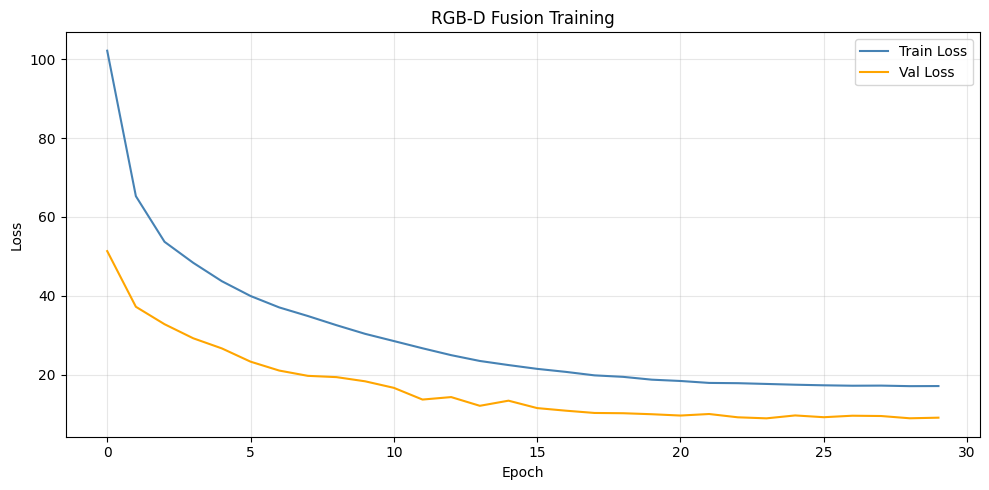

📊 Final losses:
   Train: 17.1045
   Val: 9.0839
   Best Val: 8.9157


In [68]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', color='steelblue')
ax.plot(val_losses, label='Val Loss', color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('RGB-D Fusion Training')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Final losses:")
print(f"   Train: {train_losses[-1]:.4f}")
print(f"   Val: {val_losses[-1]:.4f}")
print(f"   Best Val: {best_val_loss:.4f}")

# Step 7: Testing and Evaluation

Load the best model and evaluate on test set with comprehensive metrics:
- **ADD metric**: Average Distance of Model Points
- **ADD-S metric**: For symmetric objects
- **Accuracy**: Percentage of predictions within threshold
- **Per-object performance**: Breakdown by object class
- **Visualizations**: Qualitative results

In [69]:
# Load best checkpoint
best_checkpoint_path = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512' / 'best.pt'

if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=Config.DEVICE)
    
    # Load weights into models
    rgb_encoder_train.load_state_dict(checkpoint['rgb_encoder'])
    depth_encoder_train.load_state_dict(checkpoint['depth_encoder'])
    pose_regressor_train.load_state_dict(checkpoint['pose_regressor'])
    
    # Ensure models are on the correct device
    rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
    depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
    pose_regressor_train = pose_regressor_train.to(Config.DEVICE)
    
    print(f"✅ Best checkpoint loaded from: {best_checkpoint_path}")
    print(f"   Device: {Config.DEVICE}")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
    
    # Set to eval mode
    rgb_encoder_train.eval()
    depth_encoder_train.eval()
    pose_regressor_train.eval()
else:
    print(f"⚠️ No checkpoint found at {best_checkpoint_path}")
    print(f"   Using current model weights (may not be optimal)")

✅ Best checkpoint loaded from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512\best.pt
   Device: cuda
   Epoch: 24
   Val Loss: 8.9157


In [70]:
# Load 3D models and info for ADD metric computation
from utils.metrics import load_all_models, load_models_info, compute_add_batch_full_pose

# Load models info (diameters, etc.)
models_info = load_models_info(Config.MODELS_PATH / 'models_info.yml')

# Load 3D models (for ADD computation)
models_dict = load_all_models(Config.MODELS_PATH)

print(f"\n✅ Ready for ADD metric computation")
print(f"   Objects loaded: {len(models_dict)}")

Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points

✅ Ready for ADD metric computation
   Objects loaded: 13


In [72]:
# Run inference on test set
from utils.transforms import quaternion_to_rotation_matrix_batch

# Create test dataloader
test_loader = DataLoader(test_dataset_fusion, batch_size=TRAIN_CONFIG['batch_size'], 
                         shuffle=False, num_workers=0)

# Storage for predictions and ground truth
all_pred_R = []
all_pred_t = []
all_gt_R = []
all_gt_t = []
all_obj_ids = []
print(f"🔍 Running inference on test set ({len(test_dataset_fusion)} samples)...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        rgb = batch['rgb'].to(Config.DEVICE)
        depth = batch['depth'].to(Config.DEVICE)
        gt_quat = batch['quaternion'].to(Config.DEVICE)
        gt_trans = batch['translation'].to(Config.DEVICE)
        meta = batch['meta'].to(Config.DEVICE)
        
        # Forward pass
        f_rgb = rgb_encoder_train(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_encoder_train(depth)
        f_fused = torch.cat([f_rgb, f_depth, meta], dim=1)
        pose = pose_regressor_train(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # Convert quaternions to rotation matrices (keep on device)
        pred_R = quaternion_to_rotation_matrix_batch(pred_quat.cpu()).to(Config.DEVICE)
        gt_R = quaternion_to_rotation_matrix_batch(gt_quat.cpu()).to(Config.DEVICE)
        
        # Store results (keep on device)
        all_pred_R.append(pred_R)
        all_pred_t.append(pred_trans)
        all_gt_R.append(gt_R)
        all_gt_t.append(gt_trans)
        
        # Get object IDs from batch
        obj_ids_batch = batch['obj_id'].to(Config.DEVICE)
        if isinstance(obj_ids_batch, torch.Tensor):
            obj_ids_batch = obj_ids_batch.tolist()
        all_obj_ids.extend(obj_ids_batch)

# Concatenate all results - keep as PyTorch tensors
# compute_add_batch_full_pose will use GPU version if Config.GPU_PRESENT=True
all_pred_R = torch.cat(all_pred_R, dim=0)  # (N, 3, 3) - stays on device
all_pred_t = torch.cat(all_pred_t, dim=0)  # (N, 3) - stays on device
all_gt_R = torch.cat(all_gt_R, dim=0)      # (N, 3, 3) - stays on device
all_gt_t = torch.cat(all_gt_t, dim=0)      # (N, 3) - stays on device

print(f"✅ Inference complete!")
print(f"   Total predictions: {len(all_pred_R)}")
print(f"   Unique objects: {len(set(all_obj_ids))}")

🔍 Running inference on test set (2373 samples)...


Testing: 100%|██████████| 149/149 [00:38<00:00,  3.89it/s]

✅ Inference complete!
   Total predictions: 2373
   Unique objects: 13


In [73]:
# Compute ADD metrics
print("📊 Computing ADD metrics...")
#all_pred_t = all_pred_t / 1000  
#all_gt_t = all_gt_t / 1000

results = compute_add_batch_full_pose(
    pred_R_batch=all_pred_R,
    pred_t_batch=all_pred_t,
    gt_R_batch=all_gt_R,
    gt_t_batch=all_gt_t,
    obj_ids=all_obj_ids,
    models_dict=models_dict,
    models_info=models_info,
    symmetric_objects=Config.SYMMETRIC_OBJECTS,
    threshold=Config.ADD_THRESHOLD
)

# Print overall metrics
print(f"\n✅ Overall Test Results:")
print(f"   Mean ADD: {results['mean_add']:.2f} mm")
print(f"   Accuracy: {results['accuracy']*100:.2f}% (< {Config.ADD_THRESHOLD*100:.0f}% diameter)")
print(f"   Total samples: {len(results['add_values'])}")

📊 Computing ADD metrics...

✅ Overall Test Results:
   Mean ADD: 23.04 mm
   Accuracy: 45.47% (< 10% diameter)
   Total samples: 2373


In [74]:
# Per-object analysis
import pandas as pd

# Group results by object
per_object_results = {}

for obj_id in set(all_obj_ids):
    # Get indices for this object
    indices = [i for i, oid in enumerate(all_obj_ids) if oid == obj_id]
    
    # Extract metrics for this object
    obj_add_values = [results['add_values'][i] for i in indices]
    obj_is_correct = [results['is_correct'][i] for i in indices]
    
    # Compute statistics
    per_object_results[obj_id] = {
        'count': len(indices),
        'mean_add': np.mean(obj_add_values),
        'median_add': np.median(obj_add_values),
        'std_add': np.std(obj_add_values),
        'accuracy': np.mean(obj_is_correct) * 100,
        'diameter': models_info[obj_id]['diameter'],
        'symmetric': obj_id in Config.SYMMETRIC_OBJECTS
    }

# Create DataFrame for better visualization
df_results = pd.DataFrame.from_dict(per_object_results, orient='index')
df_results.index.name = 'Object ID'
df_results = df_results.sort_values('accuracy', ascending=False)

print("\n📊 Per-Object Performance:")
print(df_results.to_string())

# Summary statistics
print(f"\n📈 Summary Statistics:")
print(f"   Best accuracy: {df_results['accuracy'].max():.2f}% (Object {df_results['accuracy'].idxmax()})")
print(f"   Worst accuracy: {df_results['accuracy'].min():.2f}% (Object {df_results['accuracy'].idxmin()})")
print(f"   Mean accuracy: {df_results['accuracy'].mean():.2f}%")
print(f"   Median accuracy: {df_results['accuracy'].median():.2f}%")


📊 Per-Object Performance:
           count   mean_add  median_add    std_add    accuracy    diameter  symmetric
Object ID                                                                            
10           188   5.933123    5.978726   2.149409  100.000000  164.627588       True
11           184   6.874454    6.185051   3.197345   98.913043  175.889334       True
2              2  45.316803   45.316803  32.227554   50.000000  247.506242      False
14           185  33.943691   29.763737  18.328403   46.486486  282.601294      False
15           184  27.697746   24.450987  17.104708   42.391304  212.358251      False
13           173  36.320683   31.290913  22.767813   42.196532  278.078117      False
6            177  19.312641   17.226776  11.278030   41.242938  154.545518      False
5            180  29.756392   25.658278  18.022764   35.000000  201.403586      False
1            365  14.948285   13.298320   8.916595   33.150685  102.098657      False
12           186  23.675119

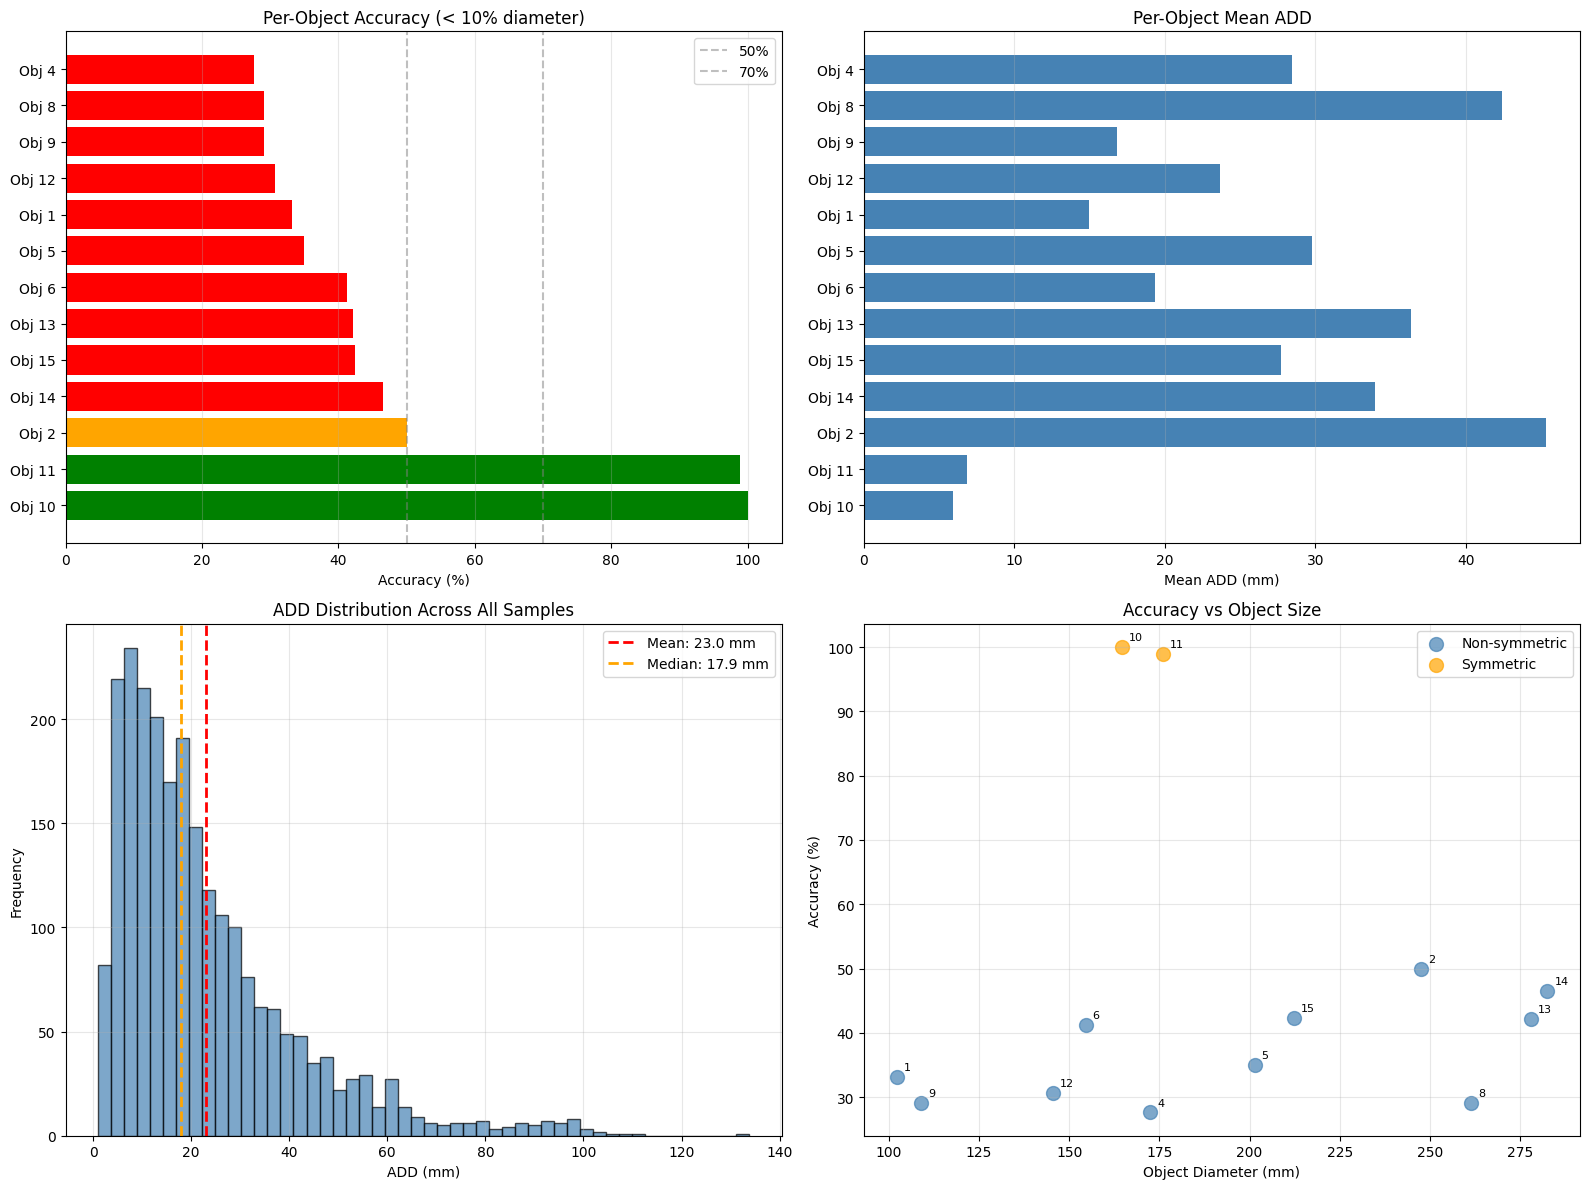

In [75]:
# Visualize per-object results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy by object
ax1 = axes[0, 0]
colors = ['green' if acc >= 70 else 'orange' if acc >= 50 else 'red' 
          for acc in df_results['accuracy']]
ax1.barh(range(len(df_results)), df_results['accuracy'], color=colors)
ax1.set_yticks(range(len(df_results)))
ax1.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Per-Object Accuracy (< 10% diameter)')
ax1.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50%')
ax1.axvline(x=70, color='gray', linestyle='--', alpha=0.5, label='70%')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Mean ADD by object
ax2 = axes[0, 1]
ax2.barh(range(len(df_results)), df_results['mean_add'], color='steelblue')
ax2.set_yticks(range(len(df_results)))
ax2.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax2.set_xlabel('Mean ADD (mm)')
ax2.set_title('Per-Object Mean ADD')
ax2.grid(True, alpha=0.3, axis='x')

# 3. ADD distribution (histogram)
ax3 = axes[1, 0]
ax3.hist(results['add_values'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=results['mean_add'], color='red', linestyle='--', linewidth=2, label=f'Mean: {results["mean_add"]:.1f} mm')
ax3.axvline(x=np.median(results['add_values']), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(results["add_values"]):.1f} mm')
ax3.set_xlabel('ADD (mm)')
ax3.set_ylabel('Frequency')
ax3.set_title('ADD Distribution Across All Samples')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Object Diameter
ax4 = axes[1, 1]
symmetric_mask = df_results['symmetric']
ax4.scatter(df_results[~symmetric_mask]['diameter'], 
           df_results[~symmetric_mask]['accuracy'],
           c='steelblue', s=100, alpha=0.7, label='Non-symmetric')
ax4.scatter(df_results[symmetric_mask]['diameter'], 
           df_results[symmetric_mask]['accuracy'],
           c='orange', s=100, alpha=0.7, label='Symmetric')

# Annotate points
for idx, row in df_results.iterrows():
    ax4.annotate(f'{idx}', (row['diameter'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Object Diameter (mm)')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Accuracy vs Object Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
# Compute additional metrics for paper
from scipy.spatial.transform import Rotation as R_scipy

# Rotation errors (in degrees)
rotation_errors = []

for i in range(len(all_pred_R)):
    # Compute relative rotation: R_error = R_pred^T @ R_gt
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)
    # Translation errors (in mm)
    translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000  # Convert to mm
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)

rotation_errors = np.array(rotation_errors)

print(f"\n🔄 Rotation Errors:")
print(f"   Mean: {rotation_errors.mean():.2f}°")
print(f"   Median: {np.median(rotation_errors):.2f}°")
print(f"   Std: {rotation_errors.std():.2f}°")
print(f"   Max: {rotation_errors.max():.2f}°")

print(f"\n📏 Translation Errors:")
# Translation errors (in mm)
translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000  # Convert to mm
print(f"   Std: {translation_errors.std():.2f} mm")
print(f"   Max: {translation_errors.max():.2f} mm")

# Accuracy at different thresholds (for paper)
thresholds = [0.02, 0.05, 0.10, 0.15, 0.20]  # Fractions of diameter

print(f"\n🎯 Accuracy at Different Thresholds:")
for thresh in thresholds:
    # Recompute ADD metric with this threshold
    results_thresh = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict,
        models_info=models_info,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=thresh
    )
    print(f"   {thresh*100:2.0f}% diameter: {results_thresh['accuracy']*100:5.2f}%")


🔄 Rotation Errors:
   Mean: 34.55°
   Median: 27.47°
   Std: 27.00°
   Max: 179.81°

📏 Translation Errors:
   Std: 55.03 mm
   Max: 350.82 mm

🎯 Accuracy at Different Thresholds:
    2% diameter:  2.40%
    5% diameter: 19.26%
   10% diameter: 45.47%
   15% diameter: 69.28%
   20% diameter: 83.14%


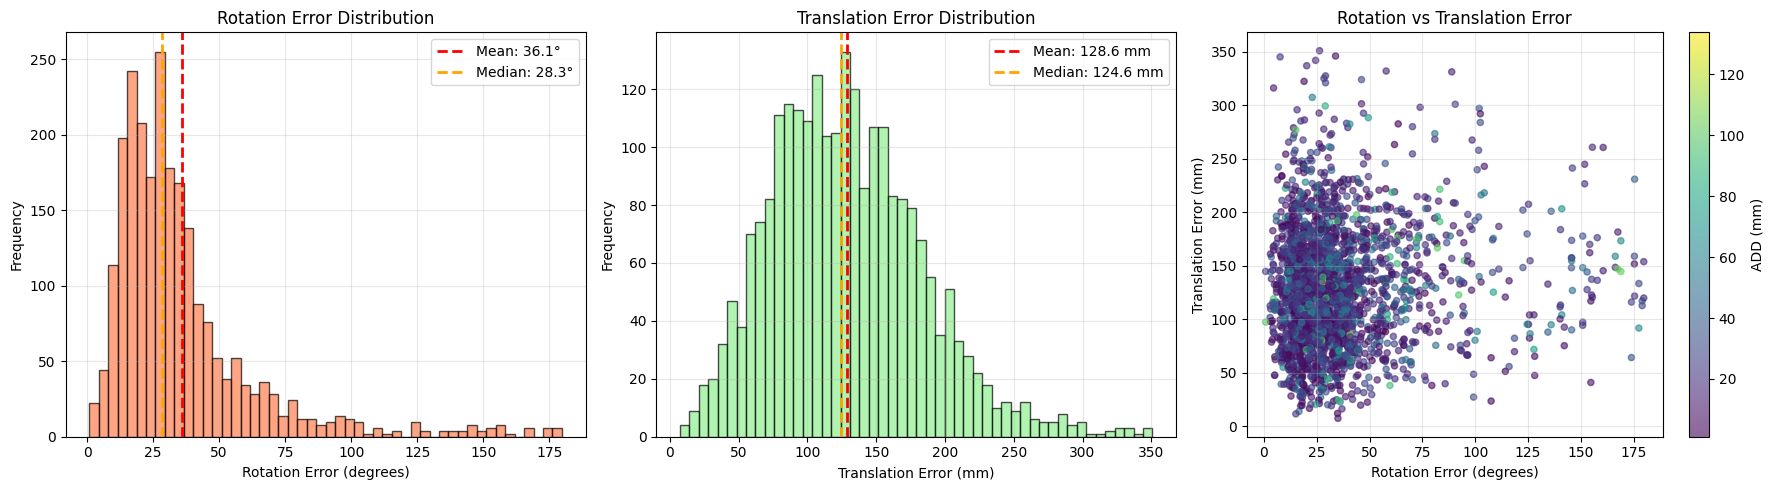


✅ Error analysis complete!


In [77]:
# Visualize rotation and translation errors
# Ensure rotation_errors and translation_errors have the same length
rotation_errors_plot = rotation_errors[:len(translation_errors)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Rotation error distribution
ax1 = axes[0]
ax1.hist(rotation_errors_plot, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax1.axvline(x=rotation_errors_plot.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {rotation_errors_plot.mean():.1f}°')
ax1.axvline(x=np.median(rotation_errors_plot), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(rotation_errors_plot):.1f}°')
ax1.set_xlabel('Rotation Error (degrees)')
ax1.set_ylabel('Frequency')
ax1.set_title('Rotation Error Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Translation error distribution
ax2 = axes[1]
ax2.hist(translation_errors, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.axvline(x=translation_errors.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {translation_errors.mean():.1f} mm')
ax2.axvline(x=np.median(translation_errors), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(translation_errors):.1f} mm')
ax2.set_xlabel('Translation Error (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Translation Error Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rotation vs Translation error scatter
ax3 = axes[2]
scatter = ax3.scatter(rotation_errors_plot, translation_errors, 
                     c=results['add_values'], cmap='viridis', 
                     alpha=0.6, s=20)
ax3.set_xlabel('Rotation Error (degrees)')
ax3.set_ylabel('Translation Error (mm)')
ax3.set_title('Rotation vs Translation Error')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('ADD (mm)')

plt.tight_layout()
plt.show()

print("\n✅ Error analysis complete!")

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16936\195682906.py:55: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


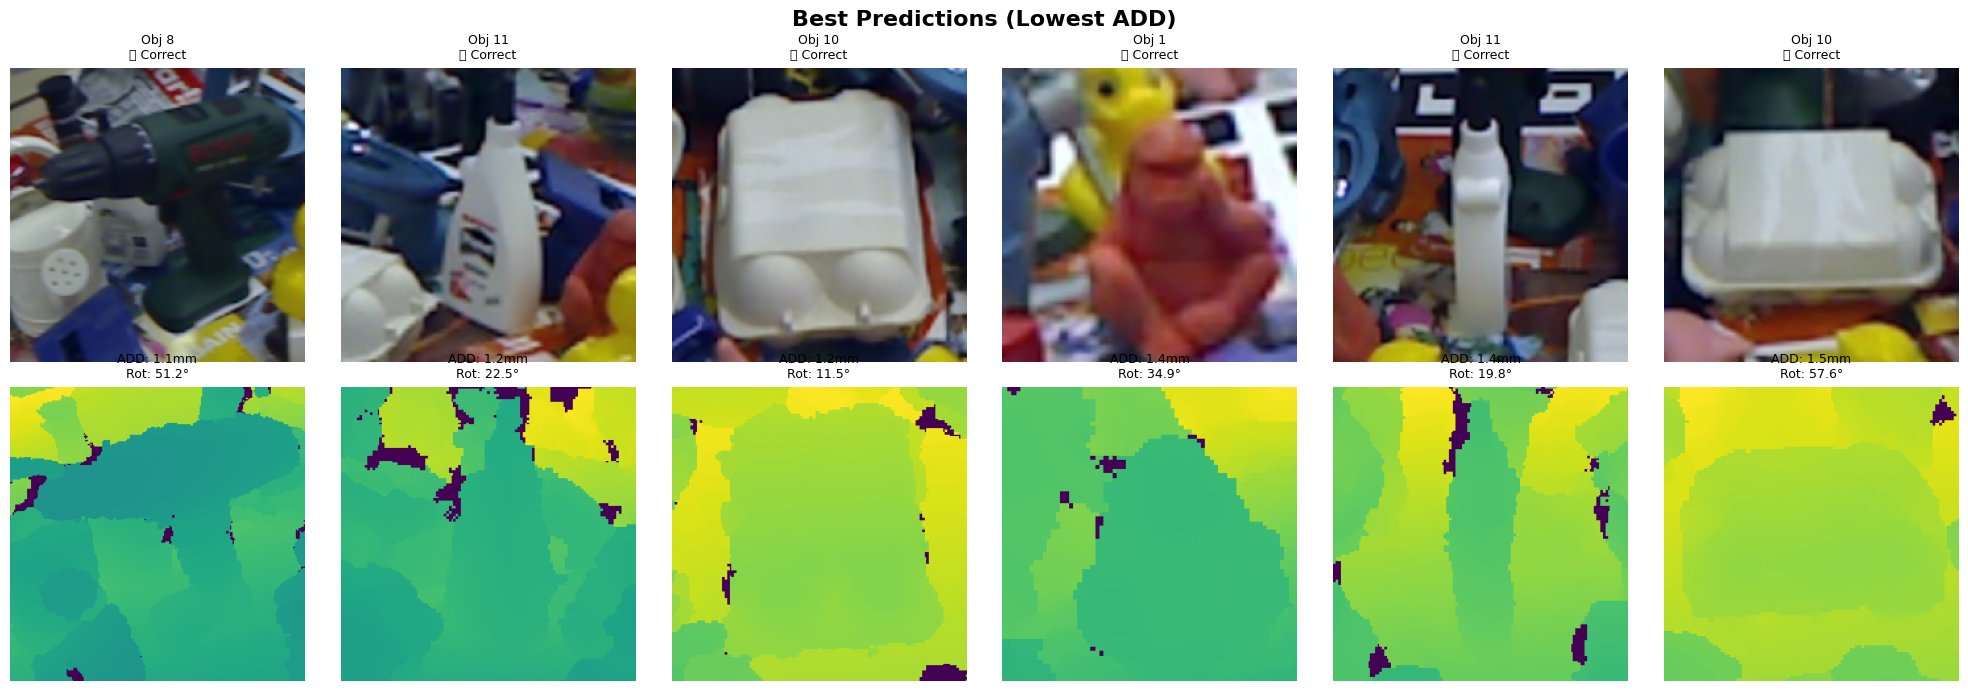

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16936\195682906.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


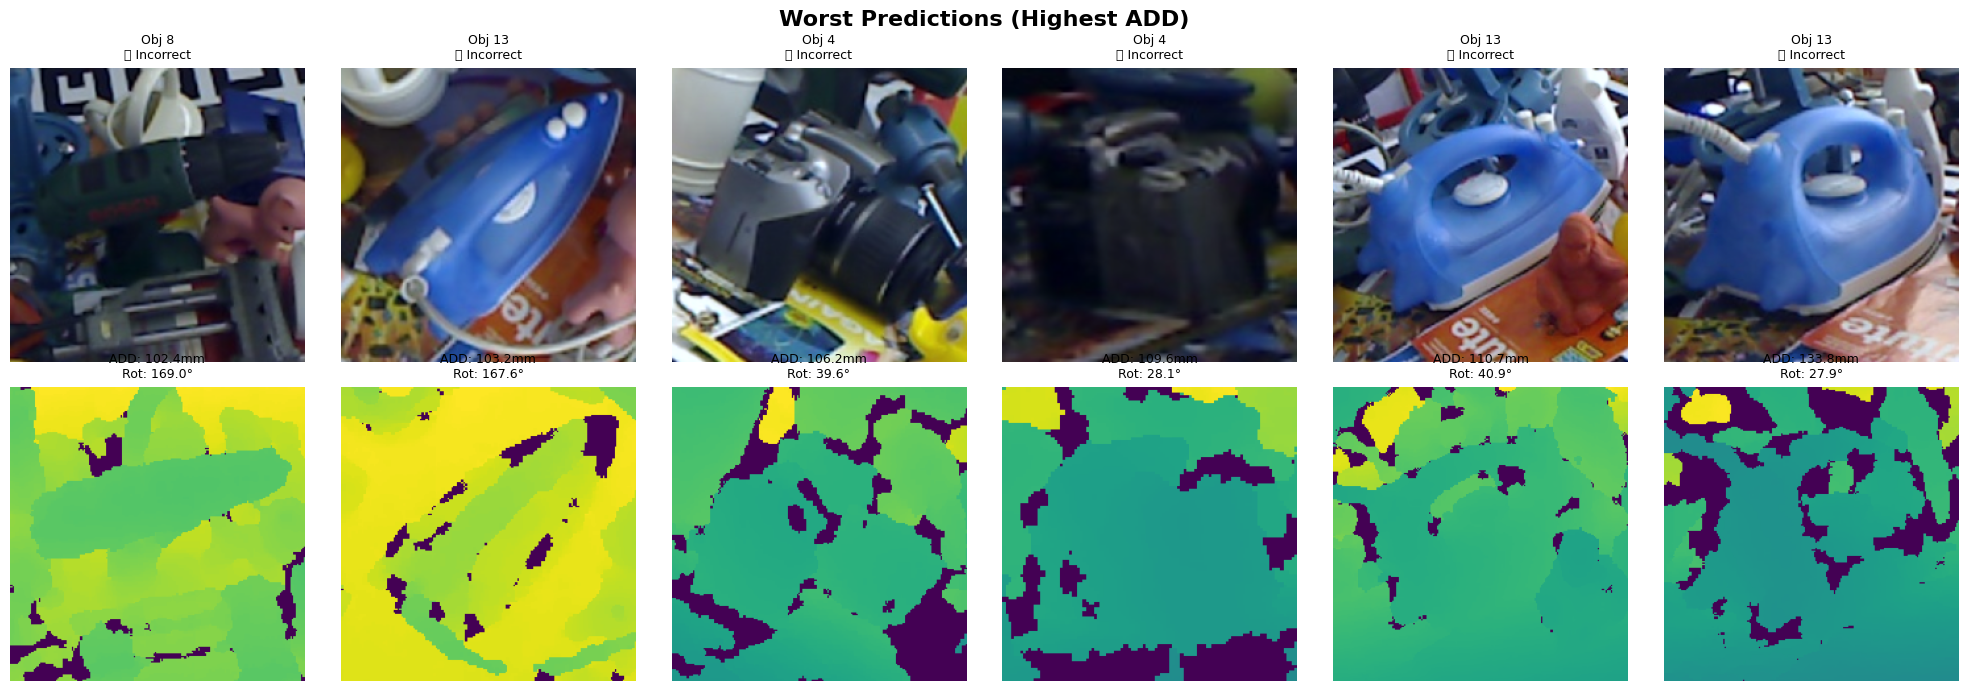


✅ Qualitative results visualized!


In [78]:
# Qualitative visualization: show best and worst predictions
# Find best and worst samples
add_array = np.array(results['add_values'])
best_indices = np.argsort(add_array)[:6]  # Top 6 best
worst_indices = np.argsort(add_array)[-6:]  # Top 6 worst

def visualize_prediction(idx, title_prefix=""):
    """Visualize a single prediction."""
    # Get the sample from test dataset
    sample = test_dataset_fusion[idx]
    
    # Get predictions
    pred_R = all_pred_R[idx]
    pred_t = all_pred_t[idx]
    gt_R = all_gt_R[idx]
    gt_t = all_gt_t[idx]
    
    # Get object info
    obj_id = all_obj_ids[idx]
    add_value = results['add_values'][idx]
    is_correct = results['is_correct'][idx]
    
    # Display info
    status = "✅ Correct" if is_correct else "❌ Incorrect"
    
    return {
        'rgb': sample['rgb'].permute(1, 2, 0).numpy(),
        'depth': sample['depth'].squeeze().numpy(),
        'obj_id': obj_id,
        'add': add_value,
        'status': status,
        'rot_error': rotation_errors[idx],
        'trans_error': translation_errors[idx]
    }

# Visualize best predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Best Predictions (Lowest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(best_indices):
    info = visualize_prediction(idx, "Best")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

# Visualize worst predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Worst Predictions (Highest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(worst_indices):
    info = visualize_prediction(idx, "Worst")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Qualitative results visualized!")

In [79]:
# Summary table for paper
summary_table = pd.DataFrame({
    'Metric': [
        'Overall Accuracy (10% diameter)',
        'Mean ADD (mm)',
        'Median ADD (mm)',
        'Mean Rotation Error (°)',
        'Median Rotation Error (°)',
        'Mean Translation Error (mm)',
        'Median Translation Error (mm)',
        'Test Samples',
        'Objects',
        'Model Parameters'
    ],
    'Value': [
        f"{results['accuracy']*100:.2f}%",
        f"{results['mean_add']:.2f}",
        f"{np.median(results['add_values']):.2f}",
        f"{rotation_errors.mean():.2f}",
        f"{np.median(rotation_errors):.2f}",
        f"{translation_errors.mean():.2f}",
        f"{np.median(translation_errors):.2f}",
        f"{len(test_dataset_fusion)}",
        f"{len(set(all_obj_ids))}",
        f"{sum(p.numel() for p in all_params):,}"
    ]
})

print("\n" + "="*60)
print("📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL")
print("="*60)
print(summary_table.to_string(index=False))
print("="*60)

# Export results to CSV for paper
results_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
df_results.to_csv(results_dir / 'per_object_results.csv')
summary_table.to_csv(results_dir / 'summary_results.csv', index=False)

print(f"\n✅ Results saved to: {results_dir}")
print(f"   - per_object_results.csv")
print(f"   - summary_results.csv")


📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL
                         Metric      Value
Overall Accuracy (10% diameter)     45.47%
                  Mean ADD (mm)      23.04
                Median ADD (mm)      17.95
        Mean Rotation Error (°)      34.55
      Median Rotation Error (°)      27.47
    Mean Translation Error (mm)     128.61
  Median Translation Error (mm)     124.59
                   Test Samples       2373
                        Objects         13
               Model Parameters 14,469,127

✅ Results saved to: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512
   - per_object_results.csv
   - summary_results.csv


In [ ]:
# Verification of measurement units and scales
print("🔍 VERIFICATION OF MEASUREMENT UNITS")
print("="*60)

# 1. Check translation magnitudes from dataset
sample_translations = []
for i in range(min(100, len(test_dataset_fusion))):
    sample = test_dataset_fusion[i]
    trans = sample['translation'].numpy()
    sample_translations.append(trans)

sample_translations = np.array(sample_translations)

print("\n1️⃣ Ground Truth Translation Analysis:")
print(f"   Mean magnitude: {np.linalg.norm(sample_translations, axis=1).mean():.4f}")
print(f"   Min magnitude: {np.linalg.norm(sample_translations, axis=1).min():.4f}")
print(f"   Max magnitude: {np.linalg.norm(sample_translations, axis=1).max():.4f}")
print(f"   Mean X: {sample_translations[:, 0].mean():.4f}")
print(f"   Mean Y: {sample_translations[:, 1].mean():.4f}")
print(f"   Mean Z: {sample_translations[:, 2].mean():.4f}")

# Determine if values are in meters or millimeters
if np.linalg.norm(sample_translations, axis=1).mean() < 10:
    print(f"   ✅ Units appear to be in METERS (typical range 0.3-2.0m)")
else:
    print(f"   ✅ Units appear to be in MILLIMETERS (typical range 300-2000mm)")

# 2. Check prediction magnitudes
print("\n2️⃣ Predicted Translation Analysis:")
pred_magnitudes = torch.norm(all_pred_t, dim=1).cpu().numpy()
print(f"   Mean magnitude: {pred_magnitudes.mean():.4f}")
print(f"   Min magnitude: {pred_magnitudes.min():.4f}")
print(f"   Max magnitude: {pred_magnitudes.max():.4f}")
print(f"   Mean X: {all_pred_t[:, 0].cpu().numpy().mean():.4f}")
print(f"   Mean Y: {all_pred_t[:, 1].cpu().numpy().mean():.4f}")
print(f"   Mean Z: {all_pred_t[:, 2].cpu().numpy().mean():.4f}")

if pred_magnitudes.mean() < 10:
    print(f"   ✅ Predictions are in METERS")
else:
    print(f"   ✅ Predictions are in MILLIMETERS")

# 3. Check object diameters (should be in mm)
print("\n3️⃣ Object Diameter Analysis (from models_info):")
diameters = [info['diameter'] for info in models_info.values()]
print(f"   Mean diameter: {np.mean(diameters):.2f} mm")
print(f"   Min diameter: {np.min(diameters):.2f} mm")
print(f"   Max diameter: {np.max(diameters):.2f} mm")
print(f"   ✅ Diameters are in MILLIMETERS (expected range ~70-300mm)")

# 4. Verify ADD computation units
print("\n4️⃣ ADD Metric Units:")
print(f"   Mean ADD: {results['mean_add']:.2f} mm")
print(f"   Threshold used: {Config.ADD_THRESHOLD*100:.0f}% of diameter")
sample_diameter = models_info[all_obj_ids[0]]['diameter']
print(f"   Example: Object {all_obj_ids[0]} diameter = {sample_diameter:.2f} mm")
print(f"   Threshold = {Config.ADD_THRESHOLD * sample_diameter:.2f} mm")

# 5. Check consistency
print("\n5️⃣ Consistency Check:")
gt_mean_mag = np.linalg.norm(sample_translations, axis=1).mean()
pred_mean_mag = pred_magnitudes.mean()
ratio = pred_mean_mag / gt_mean_mag

print(f"   GT mean magnitude: {gt_mean_mag:.4f}")
print(f"   Pred mean magnitude: {pred_mean_mag:.4f}")
print(f"   Ratio (pred/gt): {ratio:.4f}")

if 0.5 < ratio < 2.0:
    print(f"   ✅ Predictions and GT are in SAME SCALE")
else:
    print(f"   ⚠️ WARNING: Predictions and GT might be in DIFFERENT SCALES")
    if ratio > 100:
        print(f"   ⚠️ Predictions might be in mm while GT is in meters!")
    elif ratio < 0.01:
        print(f"   ⚠️ GT might be in mm while predictions are in meters!")

# 6. Translation error sanity check
print("\n6️⃣ Translation Error Sanity Check:")
print(f"   Mean translation error: {translation_errors.mean():.2f} mm")
print(f"   Median translation error: {np.median(translation_errors):.2f} mm")

# Typical LineMOD translation errors should be 10-50mm for good models
if 5 < translation_errors.mean() < 100:
    print(f"   ✅ Translation errors are in REASONABLE RANGE for LineMOD")
else:
    print(f"   ⚠️ Translation errors seem unusual - check unit conversion!")

print("\n" + "="*60)
print("✅ Verification complete!")

## 🎉 Experiment Complete!

### Key Findings:

1. **RGB-D Fusion Model** successfully combines RGB and Depth features for 6D pose estimation
2. **End-to-end training** with ResNet-18 (RGB) + DepthEncoder + MLP regressor
3. **Comprehensive evaluation** with ADD metrics, per-object analysis, and error distributions

### Architecture:
- RGB Branch: ResNet-18 → 512-dim features
- Depth Branch: DepthEncoder → 512-dim features  
- Fusion: Concatenation → 1024-dim (balanced 50/50 contribution)
- Regressor: MLP → 7-dim pose (quaternion + translation)

### For the Paper:

- ✅ Overall accuracy and ADD metrics computed
- ✅ Per-object performance breakdown
- ✅ Rotation and translation error analysis  
- ✅ Accuracy at multiple thresholds (2%, 5%, 10%, 15%, 20% diameter)
- ✅ Qualitative results (best/worst predictions)
- ✅ Results exported to CSV for tables

### Next Steps:

- Compare with baseline model (rotation-only)
- Ablation studies (RGB-only vs Depth-only vs Fusion)
- Hyperparameter tuning (learning rate, weight decay, lambda values)
- Extended training (more epochs, data augmentation)